# Noise-Based Machine Unlearning Methods for Tabular Data

## 📚 What is Machine Unlearning?

Machine unlearning is the process of making a trained model "forget" specific data points, as if they were never part of the training set. This is crucial for:

- **Privacy Compliance**: GDPR's "right to be forgotten" requires deletion of user data
- **Data Corrections**: Removing mislabeled or corrupted training samples
- **Bias Mitigation**: Eliminating problematic data that causes unfair predictions
- **Security**: Preventing memorization of sensitive information

**The Challenge**: Simply deleting data isn't enough—the model has already learned from it! Retraining from scratch is expensive and often infeasible for large models.

**The Solution**: Approximate unlearning methods that are much faster than retraining.

---

## 🎯 Noise-Based Unlearning: Core Concept

**Key Insight**: Neural networks store learned information in their parameters (weights and biases). By carefully adding noise to these parameters, we can disrupt the specific patterns associated with the forget set while preserving general knowledge.

**Why Noise Works**:
- Small random perturbations break precise memorization
- Model becomes less confident about specific forget set samples
- General patterns (shared with retain set) are more robust to noise
- Provides plausible deniability about forget set data

---

## 🔬 Methods Implemented:

### 1. **Gaussian Noise Injection** 
   - **Approach**: Add N(0, σ²) noise uniformly to all parameters
   - **Pros**: Simple, easy to tune, well-understood statistics
   - **Cons**: Treats all parameters equally (may be inefficient)
   - **Use case**: Baseline method, quick experiments

### 2. **Laplacian Noise Injection**
   - **Approach**: Add Laplace(0, b) noise to parameters
   - **Pros**: Heavier tails → better for differential privacy guarantees
   - **Cons**: More variable results, still uniform across parameters
   - **Use case**: When formal privacy guarantees are needed

### 3. **Adaptive Noise Scaling**
   - **Approach**: Scale noise based on gradient magnitude on forget set
   - **Pros**: Targets important parameters, better trade-off between forgetting/retaining
   - **Cons**: Requires forget set access, more computation
   - **Use case**: When you want efficient, targeted unlearning

### 4. **Layer-wise Noise Injection**
   - **Approach**: Apply different noise levels to different network layers
   - **Pros**: Fine-grained control, can preserve low-level features
   - **Cons**: Requires understanding of layer hierarchy
   - **Use case**: When you know which layers are most responsible for memorization

### 5. **Gradient-based Noise**
   - **Approach**: Noise magnitude directly proportional to gradient magnitude
   - **Pros**: Extremely targeted, follows loss landscape
   - **Cons**: Very sensitive to multiplier choice
   - **Use case**: Maximum targeting efficiency, research comparisons

---

## 📊 Evaluation Metrics:

We measure unlearning success using three key metrics:

1. **Forget Set Accuracy** (↓ lower is better)
   - How well the model still predicts the forget set
   - Should decrease after successful unlearning
   - Target: Approach performance on unseen data

2. **Retain Set Accuracy** (↑ higher is better)
   - How well the model still predicts the retained training data
   - Should remain high (minimal collateral damage)
   - Target: Stay close to original model performance

3. **Test Set Accuracy** (↑ higher is better)
   - Overall model generalization performance
   - Indicates if the model is still useful after unlearning
   - Target: Maintain competitive accuracy

4. **Parameter Distance** (L2 norm)
   - How much parameters changed from original model
   - Helps understand aggressiveness of unlearning
   - Larger distance = more aggressive modification

---

## 🎓 Learning Objectives:

By the end of this notebook, you will understand:
- ✅ Why machine unlearning is important
- ✅ How noise-based methods induce forgetting
- ✅ Trade-offs between different noise distributions
- ✅ How to evaluate unlearning effectiveness
- ✅ When to use each method in practice
- ✅ Comparison with "gold standard" (retrain from scratch)

---

Let's dive in! 🚀


In [17]:
# ============================================================================
# LIBRARY IMPORTS AND SETUP
# ============================================================================

# Import required libraries for data processing and visualization
import numpy as np          # Numerical operations and array handling
import pandas as pd         # Data manipulation and analysis (for results tables)
import matplotlib.pyplot as plt  # Plotting and visualization
import seaborn as sns       # Statistical visualization (enhances matplotlib)

# PyTorch imports for deep learning
import torch                # Core PyTorch library for tensor operations
import torch.nn as nn       # Neural network modules (layers, loss functions)
import torch.optim as optim # Optimization algorithms (Adam, SGD, etc.)
from torch.utils.data import TensorDataset, DataLoader, Subset  # Data handling utilities

# Scikit-learn imports for data generation and preprocessing
from sklearn.datasets import make_classification  # Generate synthetic classification datasets
from sklearn.model_selection import train_test_split  # Split data into train/test sets
from sklearn.preprocessing import StandardScaler  # Feature standardization (mean=0, std=1)
from sklearn.metrics import accuracy_score, classification_report  # Model evaluation metrics

# Utility imports
from copy import deepcopy   # Create independent copies of models (important for comparing unlearning methods)
import warnings
warnings.filterwarnings('ignore')  # Suppress warnings for cleaner output

# ============================================================================
# REPRODUCIBILITY: Set random seeds
# ============================================================================
# Setting seeds ensures that random operations (data generation, weight initialization, etc.)
# produce the same results across different runs, making experiments reproducible
np.random.seed(42)      # NumPy random operations
torch.manual_seed(42)   # PyTorch CPU operations
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)  # PyTorch GPU operations

# ============================================================================
# DEVICE CONFIGURATION
# ============================================================================
# Use GPU if available for faster computation, otherwise use CPU
# For this tabular data task, CPU is usually sufficient
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")


Using device: cpu
PyTorch version: 2.7.1


## 1. Generate Tabular Dataset


In [18]:
# ============================================================================
# DATASET GENERATION
# ============================================================================
# Create a synthetic binary classification dataset to simulate real-world tabular data
# We use synthetic data because it allows us to control all aspects of the dataset

# Dataset parameters
n_samples = 2000         # Total number of samples (moderate size for quick experimentation)
n_features = 20          # Number of input features (typical for tabular data)
n_informative = 15       # Features that actually contribute to the classification (75%)
n_redundant = 3          # Features that are linear combinations of informative features
                         # Remaining features (20-15-3=2) will be random noise

# Generate synthetic dataset using sklearn's make_classification
# This creates a realistic classification problem with controlled characteristics
X, y = make_classification(
    n_samples=n_samples,
    n_features=n_features,
    n_informative=n_informative,  # These features have predictive power
    n_redundant=n_redundant,      # These add realistic correlation between features
    n_classes=2,                  # Binary classification (0 or 1)
    random_state=42,              # For reproducibility
    flip_y=0.1                    # Flip 10% of labels to add noise (makes problem more realistic)
)

print(f"Dataset shape: {X.shape}")
print(f"Number of features: {n_features}")
print(f"Class distribution: {np.bincount(y)}")  # Check if classes are balanced


Dataset shape: (2000, 20)
Number of features: 20
Class distribution: [ 986 1014]


In [19]:
# ============================================================================
# DATA SPLITTING STRATEGY
# ============================================================================
# Machine unlearning requires three distinct sets:
# 1. RETAIN SET: Data the model should continue to remember
# 2. FORGET SET: Data the model should "forget" (simulate data deletion request)
# 3. TEST SET: Unseen data to evaluate overall model performance

# First split: Separate test set (20% of all data)
# We use stratify=y to maintain class balance in all splits
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2,  # 20% for testing (400 samples)
    random_state=42, 
    stratify=y  # Ensures both train and test have similar class distributions
)

# Second split: Divide training set into FORGET and RETAIN sets
# The forget set represents data that a user wants removed (e.g., GDPR right to be forgotten)
forget_ratio = 0.1  # 10% of training data will be the "forget set" (typical in unlearning research)
                    # This means 90% remains as the "retain set"
X_retain, X_forget, y_retain, y_forget = train_test_split(
    X_train, y_train, 
    test_size=forget_ratio,  # 10% for forgetting (160 samples)
    random_state=42, 
    stratify=y_train  # Maintain class balance in both sets
)

print(f"\nData splits:")
print(f"Retain set: {X_retain.shape[0]} samples")  # 1440 samples (72% of total)
print(f"Forget set: {X_forget.shape[0]} samples")  # 160 samples (8% of total)
print(f"Test set: {X_test.shape[0]} samples")      # 400 samples (20% of total)



Data splits:
Retain set: 1440 samples
Forget set: 160 samples
Test set: 400 samples


In [ ]:
# ============================================================================
# FEATURE STANDARDIZATION
# ============================================================================
# Neural networks perform better when input features have similar scales (mean=0, std=1)
# This prevents features with larger magnitudes from dominating the learning process

scaler = StandardScaler()  # Computes mean and std for scaling

# ============================================================================
# ⚠️  IMPORTANT DESIGN DECISION: Which data to fit scaler on?
# ============================================================================
# This is a subtle but important choice with two philosophies:
#
# 📘 APPROACH 1 (IDEALIZED - What we're using):
#    Fit scaler ONLY on retain set
#    
#    Philosophy: "Simulate a world where forget set never existed"
#    - Used in most academic unlearning papers
#    - Provides cleanest experimental setup
#    - Shows upper bound of unlearning performance
#    
#    ✅ PRO: Forget set has zero influence on preprocessing
#    ❌ CON: UNREALISTIC! (as you correctly pointed out!)
#           In practice, the scaler would have been fit on ALL data originally
#
# 📗 APPROACH 2 (REALISTIC):
#    Fit scaler on ALL training data (retain + forget)
#    
#    Philosophy: "Model was originally trained on all data, then unlearning requested"
#    - More realistic real-world scenario
#    - Scaler statistics already "contaminated" by forget set
#    - Harder unlearning challenge (forget set influenced even preprocessing)
#    
#    ✅ PRO: Matches what actually happens in production systems
#    ❌ CON: Makes it harder to isolate the unlearning method's performance
#
# ============================================================================
# YOUR VALID CRITIQUE:
# ============================================================================
# You're absolutely right that in reality:
# 1. At training time, nobody knows which data will be deleted later
# 2. The scaler would be fit on ALL available training data
# 3. Later, when deletion is requested, we're "stuck" with those statistics
# 4. We can't go back and refit the scaler without the forget set
#    (that would affect feature distributions for retain set too!)
#
# ==============xxx==============================================================
# WHY WE USE APPROACH 1 ANYWAY:
# ============================================================================
# 1. Standard practice in research (allows comparison with papers)
# 2. Isolates the unlearning method's effectiveness
# 3. Shows best-case scenario (upper bound of performance)
# 4. Simplifies the experiment (one less confounding factor)
#
# However, you could easily test APPROACH 2 by uncommenting the code below!
# ============================================================================

# CURRENT APPROACH (IDEALIZED):
X_retain_scaled = scaler.fit_transform(X_retain)  # Fit ONLY on retain set
X_forget_scaled = scaler.transform(X_forget)      # Transform using retain stats
X_test_scaled = scaler.transform(X_test)          # Transform using retain stats

# ============================================================================
# ALTERNATIVE: MORE REALISTIC APPROACH (Uncomment to try)
# ============================================================================
# This fits scaler on ALL training data, as would happen in reality:
#
# X_full_train = np.vstack([X_retain, X_forget])  # Combine all training data
# scaler.fit(X_full_train)  # Fit on ALL data (original training scenario)
# X_retain_scaled = scaler.transform(X_retain)  # Now use full stats
# X_forget_scaled = scaler.transform(X_forget)  # Same stats
# X_test_scaled = scaler.transform(X_test)      # Same stats
#
# Result: Unlearning becomes slightly harder because forget set already
#         influenced the preprocessing (mean/std calculations include it)
#
# Try both approaches and compare results to see the difference!
# ============================================================================

# ============================================================================
# CONVERT TO PYTORCH TENSORS
# ============================================================================
# PyTorch requires data in tensor format (similar to NumPy arrays but with GPU support)

# FloatTensor for input features (continuous values)
X_retain_tensor = torch.FloatTensor(X_retain_scaled).to(device)
X_forget_tensor = torch.FloatTensor(X_forget_scaled).to(device)
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)

# LongTensor for labels (class indices: 0 or 1)
# CrossEntropyLoss in PyTorch expects labels as LongTensor
y_retain_tensor = torch.LongTensor(y_retain).to(device)
y_forget_tensor = torch.LongTensor(y_forget).to(device)
y_test_tensor = torch.LongTensor(y_test).to(device)

print("\nData preparation complete!")


Data preparation complete!


## 2. Define Neural Network Model


In [ ]:
# ============================================================================
# NEURAL NETWORK MODEL DEFINITION (ENHANCED VERSION)
# ============================================================================

class TabularClassifier(nn.Module):
    """
    Deep neural network for binary classification on tabular data.
    
    Enhanced with multiple architectural options:
    - Different layer size patterns (funnel, constant, increasing, hourglass, etc.)
    - Multiple normalization options (BatchNorm, LayerNorm, none)
    - Multiple activation functions (ReLU, LeakyReLU, ELU, Tanh, GELU, Swish)
    - Dropout for regularization
    """
    
    def __init__(self, input_size, hidden_sizes=[64, 32, 16], num_classes=2, dropout=0.3,
                 normalization='batch', activation='relu'):
        """
        Initialize the neural network architecture.
        
        Args:
            input_size: Number of input features (20 in our case)
            hidden_sizes: List of hidden layer sizes or pattern name
            num_classes: Number of output classes (2 for binary classification)
            dropout: Dropout probability (0.3 = 30% of neurons randomly deactivated)
            normalization: Type of normalization to use
                - 'batch': BatchNorm1d (default, good for most cases)
                - 'layer': LayerNorm (more stable, good for small batches)
                - 'none' or None: No normalization
            activation: Activation function to use
                - 'relu': ReLU (default, fast and effective)
                - 'leakyrelu': LeakyReLU (prevents dying neurons)
                - 'elu': ELU (smooth, can have negative values)
                - 'tanh': Tanh (classic, outputs in [-1, 1])
                - 'gelu': GELU (used in transformers, smooth approximation)
                - 'swish' or 'silu': Swish/SiLU (self-gated, smooth)
        """
        super(TabularClassifier, self).__init__()
        
        self.normalization = normalization
        self.activation = activation
        
        layers = []  # Store all layers in a list
        prev_size = input_size  # Track input size for next layer
        
        # ========================================================================
        # BUILD HIDDEN LAYERS
        # ========================================================================
        for hidden_size in hidden_sizes:
            # 1. Linear (fully connected) layer
            layers.append(nn.Linear(prev_size, hidden_size))
            
            # 2. Normalization layer (optional)
            if normalization == 'batch':
                layers.append(nn.BatchNorm1d(hidden_size))
            elif normalization == 'layer':
                layers.append(nn.LayerNorm(hidden_size))
            # else: no normalization
            
            # 3. Activation function
            layers.append(self._get_activation(activation))
            
            # 4. Dropout
            layers.append(nn.Dropout(dropout))
            
            prev_size = hidden_size
        
        # ========================================================================
        # OUTPUT LAYER
        # ========================================================================
        layers.append(nn.Linear(prev_size, num_classes))
        
        self.network = nn.Sequential(*layers)
        
    def _get_activation(self, activation):
        """Get activation function by name."""
        activation = activation.lower()
        if activation == 'relu':
            return nn.ReLU()
        elif activation == 'leakyrelu':
            return nn.LeakyReLU(0.1)
        elif activation == 'elu':
            return nn.ELU()
        elif activation == 'tanh':
            return nn.Tanh()
        elif activation == 'gelu':
            return nn.GELU()
        elif activation in ['swish', 'silu']:
            return nn.SiLU()
        else:
            raise ValueError(f"Unknown activation: {activation}")
        
    def forward(self, x):
        """Forward pass: compute predictions from input."""
        return self.network(x)
    
    def get_layer_names(self):
        """Get names of linear layers for targeted noise injection."""
        return [name for name, module in self.named_modules() if isinstance(module, nn.Linear)]


# ============================================================================
# HELPER FUNCTION: GENERATE LAYER ARCHITECTURES
# ============================================================================

def generate_layer_architecture(input_size, pattern='funnel', num_layers=3, base_size=64):
    """
    Generate different layer size patterns for experimentation.
    
    Args:
        input_size: Number of input features
        pattern: Architecture pattern
            - 'funnel' or 'decreasing': Decreasing sizes (64 → 32 → 16)
            - 'constant': Same size (64 → 64 → 64)
            - 'increasing': Increasing sizes (16 → 32 → 64)
            - 'hourglass': Decrease then increase (64 → 32 → 64)
            - 'wide': Very wide layers (128 → 128 → 128)
            - 'deep_narrow': Many narrow layers (32 → 32 → 32 → 32 → 32)
        num_layers: Number of hidden layers
        base_size: Base size for calculations
    
    Returns:
        List of layer sizes
    """
    if pattern in ['funnel', 'decreasing']:
        # Progressive decrease: good for compression
        return [base_size // (2**i) for i in range(num_layers)]
    
    elif pattern == 'constant':
        # Same size throughout: simpler architecture
        return [base_size] * num_layers
    
    elif pattern == 'increasing':
        # Progressive increase: expands representation
        return [base_size // (2**(num_layers-1-i)) for i in range(num_layers)]
    
    elif pattern == 'hourglass':
        # Compress then expand: bottleneck architecture
        sizes = []
        mid = num_layers // 2
        for i in range(num_layers):
            if i <= mid:
                sizes.append(base_size // (2**i))
            else:
                sizes.append(base_size // (2**(num_layers-1-i)))
        return sizes
    
    elif pattern == 'wide':
        # Wide layers: more capacity
        return [base_size * 2] * num_layers
    
    elif pattern == 'deep_narrow':
        # Many small layers: deep architecture
        return [base_size // 2] * (num_layers * 2)
    
    else:
        raise ValueError(f"Unknown pattern: {pattern}")


# ============================================================================
# TESTING FUNCTION: COMPARE ARCHITECTURES
# ============================================================================

def test_architecture_config(config_name, hidden_sizes, normalization='batch', 
                            activation='relu', dropout=0.3, epochs=50, verbose=False):
    """
    Test a specific architecture configuration.
    
    Args:
        config_name: Name for this configuration
        hidden_sizes: List of hidden layer sizes
        normalization: Normalization type
        activation: Activation function
        dropout: Dropout rate
        epochs: Number of training epochs
        verbose: Print training progress
    
    Returns:
        Dictionary with results
    """
    # Create model
    test_model = TabularClassifier(
        input_size=n_features,
        hidden_sizes=hidden_sizes,
        num_classes=2,
        dropout=dropout,
        normalization=normalization,
        activation=activation
    ).to(device)
    
    # Train on full training set
    X_full_train = torch.cat([X_retain_tensor, X_forget_tensor], dim=0)
    y_full_train = torch.cat([y_retain_tensor, y_forget_tensor], dim=0)
    
    _ = train_model(test_model, X_full_train, y_full_train, epochs=epochs, lr=0.001, verbose=verbose)
    
    # Evaluate
    retain_acc = evaluate_model(test_model, X_retain_tensor, y_retain_tensor)
    forget_acc = evaluate_model(test_model, X_forget_tensor, y_forget_tensor)
    test_acc = evaluate_model(test_model, X_test_tensor, y_test_tensor)
    
    # Count parameters
    total_params = sum(p.numel() for p in test_model.parameters())
    
    return {
        'config': config_name,
        'hidden_sizes': hidden_sizes,
        'normalization': normalization,
        'activation': activation,
        'retain_acc': retain_acc,
        'forget_acc': forget_acc,
        'test_acc': test_acc,
        'total_params': total_params
    }

# ============================================================================
# MODEL INSTANTIATION
# ============================================================================
# Create the model with specified architecture
model = TabularClassifier(
    input_size=n_features,     # 20 input features
    hidden_sizes=[64, 32, 16], # Three hidden layers with decreasing sizes
                                # Why this architecture?
                                # - 64: First layer extracts basic patterns
                                # - 32: Second layer combines basic patterns
                                # - 16: Third layer creates high-level representations
    num_classes=2,             # Binary classification (0 or 1)
    dropout=0.3                # 30% dropout for regularization
).to(device)  # Move model to GPU if available

print("Model Architecture:")
print(model)

# Calculate total number of learnable parameters
# More parameters = more capacity but also more risk of overfitting
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nTotal parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

# Typical parameter count for this architecture:
# Layer 1: (20 * 64) + 64 = 1,344 parameters (weights + bias)
# Layer 2: (64 * 32) + 32 = 2,080 parameters
# Layer 3: (32 * 16) + 16 = 528 parameters
# Layer 4: (16 * 2) + 2 = 34 parameters
# Plus BatchNorm parameters (2 per layer: gamma and beta)
# Total: ~4,000-5,000 parameters (moderate size, good for our dataset)


Model Architecture:
TabularClassifier(
  (network): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=32, out_features=16, bias=True)
    (9): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=16, out_features=2, bias=True)
  )
)

Total parameters: 4210
Trainable parameters: 4210


### 2.1 Architecture Experimentation

Now let's experiment with different architecture configurations to see what works best for our data!


In [ ]:
# ============================================================================
# EXPERIMENT 1: COMPARE DIFFERENT LAYER ARCHITECTURES
# ============================================================================
print("=" * 80)
print("EXPERIMENT 1: Testing Different Layer Architecture Patterns")
print("=" * 80)

# Test different architecture patterns
architecture_results = []

patterns = ['funnel', 'constant', 'increasing', 'hourglass']
for pattern in patterns:
    print(f"\nTesting {pattern} architecture...")
    hidden_sizes = generate_layer_architecture(n_features, pattern=pattern, num_layers=3, base_size=64)
    print(f"  Layer sizes: {hidden_sizes}")
    
    result = test_architecture_config(
        config_name=f"{pattern.capitalize()} ({hidden_sizes})",
        hidden_sizes=hidden_sizes,
        normalization='batch',
        activation='relu',
        dropout=0.3,
        epochs=50,
        verbose=False
    )
    architecture_results.append(result)
    print(f"  Results: Retain={result['retain_acc']:.2f}%, Forget={result['forget_acc']:.2f}%, Test={result['test_acc']:.2f}%, Params={result['total_params']}")

# Display results
arch_df = pd.DataFrame(architecture_results)
print("\n" + "=" * 80)
print("Architecture Pattern Results:")
print("=" * 80)
print(arch_df[['config', 'retain_acc', 'forget_acc', 'test_acc', 'total_params']].to_string(index=False))
print("=" * 80)


# ============================================================================
# EXPERIMENT 2: COMPARE DIFFERENT NORMALIZATION METHODS
# ============================================================================
print("\n\n" + "=" * 80)
print("EXPERIMENT 2: Testing Different Normalization Methods")
print("=" * 80)

normalization_results = []
norm_types = ['batch', 'layer', 'none']

for norm in norm_types:
    print(f"\nTesting {norm} normalization...")
    
    result = test_architecture_config(
        config_name=f"Norm: {norm}",
        hidden_sizes=[64, 32, 16],
        normalization=norm,
        activation='relu',
        dropout=0.3,
        epochs=50,
        verbose=False
    )
    normalization_results.append(result)
    print(f"  Results: Retain={result['retain_acc']:.2f}%, Forget={result['forget_acc']:.2f}%, Test={result['test_acc']:.2f}%")

# Display results
norm_df = pd.DataFrame(normalization_results)
print("\n" + "=" * 80)
print("Normalization Method Results:")
print("=" * 80)
print(norm_df[['config', 'retain_acc', 'forget_acc', 'test_acc']].to_string(index=False))
print("=" * 80)


# ============================================================================
# EXPERIMENT 3: COMPARE DIFFERENT ACTIVATION FUNCTIONS
# ============================================================================
print("\n\n" + "=" * 80)
print("EXPERIMENT 3: Testing Different Activation Functions")
print("=" * 80)

activation_results = []
activations = ['relu', 'leakyrelu', 'elu', 'tanh', 'gelu', 'swish']

for act in activations:
    print(f"\nTesting {act} activation...")
    
    result = test_architecture_config(
        config_name=f"Act: {act}",
        hidden_sizes=[64, 32, 16],
        normalization='batch',
        activation=act,
        dropout=0.3,
        epochs=50,
        verbose=False
    )
    activation_results.append(result)
    print(f"  Results: Retain={result['retain_acc']:.2f}%, Forget={result['forget_acc']:.2f}%, Test={result['test_acc']:.2f}%")

# Display results
act_df = pd.DataFrame(activation_results)
print("\n" + "=" * 80)
print("Activation Function Results:")
print("=" * 80)
print(act_df[['config', 'retain_acc', 'forget_acc', 'test_acc']].to_string(index=False))
print("=" * 80)


# ============================================================================
# EXPERIMENT 4: VISUALIZE COMPARISONS
# ============================================================================
print("\n\nGenerating comparison visualizations...")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Architecture Configuration Comparison', fontsize=16, fontweight='bold')

# 1. Architecture patterns
ax = axes[0]
x_pos = np.arange(len(arch_df))
width = 0.25
ax.bar(x_pos - width, arch_df['retain_acc'], width, label='Retain', alpha=0.8)
ax.bar(x_pos, arch_df['forget_acc'], width, label='Forget', alpha=0.8)
ax.bar(x_pos + width, arch_df['test_acc'], width, label='Test', alpha=0.8)
ax.set_ylabel('Accuracy (%)', fontsize=11)
ax.set_title('Layer Architecture Patterns', fontsize=12)
ax.set_xticks(x_pos)
ax.set_xticklabels([p.split()[0] for p in patterns], rotation=0)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# 2. Normalization methods
ax = axes[1]
x_pos = np.arange(len(norm_df))
ax.bar(x_pos - width, norm_df['retain_acc'], width, label='Retain', alpha=0.8)
ax.bar(x_pos, norm_df['forget_acc'], width, label='Forget', alpha=0.8)
ax.bar(x_pos + width, norm_df['test_acc'], width, label='Test', alpha=0.8)
ax.set_ylabel('Accuracy (%)', fontsize=11)
ax.set_title('Normalization Methods', fontsize=12)
ax.set_xticks(x_pos)
ax.set_xticklabels(norm_types, rotation=0)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# 3. Activation functions
ax = axes[2]
x_pos = np.arange(len(act_df))
ax.bar(x_pos - width, act_df['retain_acc'], width, label='Retain', alpha=0.8)
ax.bar(x_pos, act_df['forget_acc'], width, label='Forget', alpha=0.8)
ax.bar(x_pos + width, act_df['test_acc'], width, label='Test', alpha=0.8)
ax.set_ylabel('Accuracy (%)', fontsize=11)
ax.set_title('Activation Functions', fontsize=12)
ax.set_xticks(x_pos)
ax.set_xticklabels(activations, rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


# ============================================================================
# EXPERIMENT 5: CUSTOM COMBINATIONS
# ============================================================================
print("\n\n" + "=" * 80)
print("EXPERIMENT 5: Testing Custom Combinations")
print("=" * 80)
print("Now testing some promising combinations based on results above...")

# Test a few custom combinations
custom_configs = [
    {'name': 'Best Overall', 'arch': 'funnel', 'norm': 'batch', 'act': 'relu'},
    {'name': 'Alternative 1', 'arch': 'constant', 'norm': 'layer', 'act': 'leakyrelu'},
    {'name': 'Alternative 2', 'arch': 'hourglass', 'norm': 'batch', 'act': 'gelu'},
    {'name': 'No Norm', 'arch': 'funnel', 'norm': 'none', 'act': 'elu'},
]

custom_results = []

for config in custom_configs:
    print(f"\nTesting {config['name']}: arch={config['arch']}, norm={config['norm']}, act={config['act']}")
    hidden_sizes = generate_layer_architecture(n_features, pattern=config['arch'], num_layers=3, base_size=64)
    
    result = test_architecture_config(
        config_name=config['name'],
        hidden_sizes=hidden_sizes,
        normalization=config['norm'],
        activation=config['act'],
        dropout=0.3,
        epochs=50,
        verbose=False
    )
    custom_results.append(result)
    print(f"  Results: Retain={result['retain_acc']:.2f}%, Forget={result['forget_acc']:.2f}%, Test={result['test_acc']:.2f}%")

# Display results
custom_df = pd.DataFrame(custom_results)
print("\n" + "=" * 80)
print("Custom Combination Results:")
print("=" * 80)
print(custom_df[['config', 'normalization', 'activation', 'retain_acc', 'forget_acc', 'test_acc']].to_string(index=False))
print("=" * 80)

print("\n✅ Architecture experimentation complete!")
print("💡 Use these results to choose the best configuration for your unlearning experiments.")


### Quick Reference: How to Create Custom Architectures

Here are some quick examples for creating your own custom model configurations:


In [ ]:
# ============================================================================
# QUICK EXAMPLES: Creating Custom Architectures
# ============================================================================

print("=" * 80)
print("QUICK REFERENCE: Custom Architecture Examples")
print("=" * 80)

# Example 1: Basic model with different activation
print("\n1. Model with LeakyReLU activation:")
model_leaky = TabularClassifier(
    input_size=n_features,
    hidden_sizes=[64, 32, 16],
    num_classes=2,
    dropout=0.3,
    normalization='batch',
    activation='leakyrelu'  # Just change this!
)
print(f"   Created model with {sum(p.numel() for p in model_leaky.parameters())} parameters")

# Example 2: Model with LayerNorm instead of BatchNorm
print("\n2. Model with LayerNorm:")
model_ln = TabularClassifier(
    input_size=n_features,
    hidden_sizes=[64, 32, 16],
    num_classes=2,
    dropout=0.3,
    normalization='layer',  # Change normalization
    activation='relu'
)
print(f"   Created model with {sum(p.numel() for p in model_ln.parameters())} parameters")

# Example 3: Model with no normalization
print("\n3. Model with no normalization:")
model_no_norm = TabularClassifier(
    input_size=n_features,
    hidden_sizes=[64, 32, 16],
    num_classes=2,
    dropout=0.3,
    normalization='none',  # No normalization
    activation='relu'
)
print(f"   Created model with {sum(p.numel() for p in model_no_norm.parameters())} parameters")

# Example 4: Using architecture patterns
print("\n4. Model with constant layer sizes:")
constant_layers = generate_layer_architecture(n_features, pattern='constant', num_layers=3, base_size=64)
print(f"   Generated layers: {constant_layers}")
model_constant = TabularClassifier(
    input_size=n_features,
    hidden_sizes=constant_layers,
    num_classes=2,
    dropout=0.3,
    normalization='batch',
    activation='relu'
)
print(f"   Created model with {sum(p.numel() for p in model_constant.parameters())} parameters")

# Example 5: Hourglass architecture with GELU activation
print("\n5. Hourglass architecture with GELU:")
hourglass_layers = generate_layer_architecture(n_features, pattern='hourglass', num_layers=4, base_size=64)
print(f"   Generated layers: {hourglass_layers}")
model_hourglass = TabularClassifier(
    input_size=n_features,
    hidden_sizes=hourglass_layers,
    num_classes=2,
    dropout=0.3,
    normalization='batch',
    activation='gelu'
)
print(f"   Created model with {sum(p.numel() for p in model_hourglass.parameters())} parameters")

# Example 6: Wide network with Swish activation
print("\n6. Wide network with Swish activation:")
wide_layers = generate_layer_architecture(n_features, pattern='wide', num_layers=3, base_size=64)
print(f"   Generated layers: {wide_layers}")
model_wide = TabularClassifier(
    input_size=n_features,
    hidden_sizes=wide_layers,
    num_classes=2,
    dropout=0.2,  # Lower dropout for wider network
    normalization='batch',
    activation='swish'
)
print(f"   Created model with {sum(p.numel() for p in model_wide.parameters())} parameters")

# Example 7: Deep narrow network with ELU
print("\n7. Deep narrow network with ELU:")
deep_layers = generate_layer_architecture(n_features, pattern='deep_narrow', num_layers=3, base_size=64)
print(f"   Generated layers: {deep_layers}")
model_deep = TabularClassifier(
    input_size=n_features,
    hidden_sizes=deep_layers,
    num_classes=2,
    dropout=0.4,  # Higher dropout for deeper network
    normalization='batch',
    activation='elu'
)
print(f"   Created model with {sum(p.numel() for p in model_deep.parameters())} parameters")

# Example 8: Custom layer sizes with your own list
print("\n8. Custom layer sizes (manual):")
custom_layers = [128, 64, 32, 16, 8]  # Your own sizes!
model_custom = TabularClassifier(
    input_size=n_features,
    hidden_sizes=custom_layers,
    num_classes=2,
    dropout=0.3,
    normalization='batch',
    activation='relu'
)
print(f"   Custom layers: {custom_layers}")
print(f"   Created model with {sum(p.numel() for p in model_custom.parameters())} parameters")

print("\n" + "=" * 80)
print("\n💡 SUMMARY OF OPTIONS:")
print("\nArchitecture Patterns (use with generate_layer_architecture):")
print("  • 'funnel' or 'decreasing': [64, 32, 16] - Good for compression")
print("  • 'constant': [64, 64, 64] - Simpler, consistent capacity")
print("  • 'increasing': [16, 32, 64] - Expands representation")
print("  • 'hourglass': [64, 32, 16, 32, 64] - Bottleneck in middle")
print("  • 'wide': [128, 128, 128] - More capacity")
print("  • 'deep_narrow': [32, 32, 32, 32, 32, 32] - Many small layers")

print("\nNormalization Options:")
print("  • 'batch': BatchNorm1d (default, good for most cases)")
print("  • 'layer': LayerNorm (more stable, good for small batches)")
print("  • 'none': No normalization")

print("\nActivation Functions:")
print("  • 'relu': Fast, standard choice")
print("  • 'leakyrelu': Prevents dying neurons")
print("  • 'elu': Smooth, can be negative")
print("  • 'tanh': Classic, bounded [-1, 1]")
print("  • 'gelu': Modern, used in transformers")
print("  • 'swish'/'silu': Self-gated, smooth")

print("\n" + "=" * 80)
print("✅ You can now mix and match any combination!")


### Testing Your Own Configuration

Want to quickly test your own custom configuration? Use this template:


In [ ]:
# ============================================================================
# TEMPLATE: Test Your Own Configuration
# ============================================================================
# Modify the parameters below to test your own custom architecture!

# 🔧 CUSTOMIZE THESE PARAMETERS:
MY_ARCHITECTURE = 'funnel'  # Options: 'funnel', 'constant', 'increasing', 'hourglass', 'wide', 'deep_narrow'
MY_NORMALIZATION = 'batch'  # Options: 'batch', 'layer', 'none'
MY_ACTIVATION = 'relu'      # Options: 'relu', 'leakyrelu', 'elu', 'tanh', 'gelu', 'swish'
MY_DROPOUT = 0.3           # Range: 0.0 to 0.5 (higher = more regularization)
MY_NUM_LAYERS = 3          # Number of hidden layers
MY_BASE_SIZE = 64          # Base size for layer generation

# Or specify custom layer sizes directly (uncomment to use):
# MY_CUSTOM_LAYERS = [128, 64, 32, 16]  # Your custom sizes

# ============================================================================

print("Testing your custom configuration...")
print("=" * 80)

# Generate layer sizes (or use custom ones)
if 'MY_CUSTOM_LAYERS' in locals():
    my_layers = MY_CUSTOM_LAYERS
    print(f"Using custom layers: {my_layers}")
else:
    my_layers = generate_layer_architecture(n_features, pattern=MY_ARCHITECTURE, 
                                           num_layers=MY_NUM_LAYERS, base_size=MY_BASE_SIZE)
    print(f"Generated {MY_ARCHITECTURE} architecture: {my_layers}")

# Test the configuration
my_result = test_architecture_config(
    config_name=f"My Config",
    hidden_sizes=my_layers,
    normalization=MY_NORMALIZATION,
    activation=MY_ACTIVATION,
    dropout=MY_DROPOUT,
    epochs=50,  # Change if you want faster/slower training
    verbose=False
)

print("\n" + "=" * 80)
print("YOUR CONFIGURATION RESULTS:")
print("=" * 80)
print(f"Architecture Pattern: {MY_ARCHITECTURE}")
print(f"Layer Sizes: {my_layers}")
print(f"Normalization: {MY_NORMALIZATION}")
print(f"Activation: {MY_ACTIVATION}")
print(f"Dropout: {MY_DROPOUT}")
print(f"\nRetain Set Accuracy: {my_result['retain_acc']:.2f}%")
print(f"Forget Set Accuracy: {my_result['forget_acc']:.2f}%")
print(f"Test Set Accuracy: {my_result['test_acc']:.2f}%")
print(f"Total Parameters: {my_result['total_params']:,}")
print("=" * 80)

# Optional: Compare with baseline (original funnel architecture)
baseline_result = test_architecture_config(
    config_name="Baseline",
    hidden_sizes=[64, 32, 16],
    normalization='batch',
    activation='relu',
    dropout=0.3,
    epochs=50,
    verbose=False
)

print("\nCOMPARISON WITH BASELINE:")
print("=" * 80)
print(f"{'Metric':<25} | {'Your Config':>15} | {'Baseline':>15} | {'Difference':>15}")
print("-" * 80)
print(f"{'Retain Accuracy':<25} | {my_result['retain_acc']:>14.2f}% | {baseline_result['retain_acc']:>14.2f}% | {my_result['retain_acc']-baseline_result['retain_acc']:>+14.2f}%")
print(f"{'Forget Accuracy':<25} | {my_result['forget_acc']:>14.2f}% | {baseline_result['forget_acc']:>14.2f}% | {my_result['forget_acc']-baseline_result['forget_acc']:>+14.2f}%")
print(f"{'Test Accuracy':<25} | {my_result['test_acc']:>14.2f}% | {baseline_result['test_acc']:>14.2f}% | {my_result['test_acc']-baseline_result['test_acc']:>+14.2f}%")
print(f"{'Parameters':<25} | {my_result['total_params']:>15,} | {baseline_result['total_params']:>15,} | {my_result['total_params']-baseline_result['total_params']:>+15,}")
print("=" * 80)

if my_result['test_acc'] > baseline_result['test_acc']:
    print("\n🎉 Your configuration outperforms the baseline!")
elif my_result['test_acc'] == baseline_result['test_acc']:
    print("\n✅ Your configuration matches the baseline performance.")
else:
    print("\n💡 Baseline performs better. Try adjusting your parameters!")

print("\n💡 TIP: Modify the parameters at the top of this cell and run again to experiment!")


## 3. Training and Evaluation Functions


In [22]:
# ============================================================================
# TRAINING AND EVALUATION UTILITY FUNCTIONS
# ============================================================================

def train_model(model, X_train, y_train, epochs=50, batch_size=32, lr=0.001, verbose=True):
    """
    Train the neural network using standard supervised learning.
    
    Args:
        model: The neural network to train
        X_train: Training features (tensor)
        y_train: Training labels (tensor)
        epochs: Number of complete passes through the dataset
                - More epochs = more learning but risk of overfitting
                - We use 50-100 epochs as a good balance
        batch_size: Number of samples processed before updating weights
                    - Smaller batches (16-32): More noise, better generalization, slower
                    - Larger batches (128-256): More stable, faster, may overfit
                    - 32 is a good default for small-medium datasets
        lr: Learning rate for Adam optimizer
            - Too high (>0.01): Training may diverge (loss explodes)
            - Too low (<0.0001): Training too slow, may get stuck
            - 0.001 is a safe default for Adam
        verbose: Whether to print training progress
    
    Returns:
        losses: List of average loss per epoch (for plotting convergence)
    """
    model.train()  # Set model to training mode (enables dropout and batch norm updates)
    
    # ========================================================================
    # LOSS FUNCTION
    # ========================================================================
    # CrossEntropyLoss combines log_softmax and negative log likelihood
    # It's the standard loss for multi-class classification
    # For binary classification, it automatically handles both classes
    criterion = nn.CrossEntropyLoss()
    
    # ========================================================================
    # OPTIMIZER: Adam (Adaptive Moment Estimation)
    # ========================================================================
    # Why Adam over SGD?
    # - Adapts learning rate per parameter (good for sparse gradients)
    # - Includes momentum (accelerates convergence)
    # - Less sensitive to learning rate choice
    # - Generally works well out-of-the-box
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # ========================================================================
    # DATA LOADER
    # ========================================================================
    # DataLoader handles batching and shuffling automatically
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size,  # Process 32 samples at a time
        shuffle=True  # Shuffle data each epoch (prevents learning order-dependent patterns)
    )
    
    losses = []  # Track loss over time to monitor convergence
    
    # ========================================================================
    # TRAINING LOOP
    # ========================================================================
    for epoch in range(epochs):
        epoch_loss = 0.0
        
        # Process data in mini-batches
        for batch_X, batch_y in train_loader:
            # Step 1: Clear gradients from previous batch
            # (PyTorch accumulates gradients by default)
            optimizer.zero_grad()
            
            # Step 2: Forward pass - compute predictions
            outputs = model(batch_X)
            
            # Step 3: Compute loss - how wrong are the predictions?
            loss = criterion(outputs, batch_y)
            
            # Step 4: Backward pass - compute gradients via backpropagation
            # This calculates ∂loss/∂weight for all parameters
            loss.backward()
            
            # Step 5: Update parameters using gradients
            # New weight = Old weight - learning_rate * gradient
            optimizer.step()
            
            epoch_loss += loss.item()  # Accumulate loss for this epoch
        
        # Calculate average loss across all batches
        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)
        
        # Print progress every 10 epochs
        if verbose and (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')
    
    return losses

def evaluate_model(model, X, y):
    """
    Evaluate model accuracy on a dataset.
    
    This is used to measure:
    - Retain set accuracy: How well model remembers retained data
    - Forget set accuracy: How well model remembers forgotten data (should decrease after unlearning)
    - Test set accuracy: Overall model performance on unseen data
    
    Args:
        model: Trained neural network
        X: Features to evaluate on
        y: True labels
    
    Returns:
        accuracy: Percentage of correctly classified samples (0-100)
    """
    model.eval()  # Set to evaluation mode (disables dropout, uses batch norm running stats)
    
    # torch.no_grad() disables gradient computation (saves memory and speeds up inference)
    with torch.no_grad():
        # Get model predictions
        outputs = model(X)  # Shape: (n_samples, n_classes)
        
        # Get predicted class (argmax of output logits)
        # outputs.data contains raw logits for each class
        # torch.max returns (max_values, indices) - we only need indices
        _, predicted = torch.max(outputs.data, 1)  # 1 means take max along class dimension
        
        # Calculate accuracy
        correct = (predicted == y).sum().item()  # Count correct predictions
        total = y.size(0)  # Total number of samples
        accuracy = 100 * correct / total
    
    return accuracy

def get_model_state_dict_copy(model):
    """
    Create a deep copy of model's parameters (weights and biases).
    
    Why do we need this?
    - To save original model state before applying unlearning
    - To compare how much parameters changed after unlearning
    - .clone().detach() creates independent copy (changes won't affect original)
    
    Args:
        model: PyTorch model
    
    Returns:
        Dictionary mapping parameter names to their cloned tensors
    """
    return {name: param.clone().detach() for name, param in model.state_dict().items()}

def calculate_parameter_distance(state_dict1, state_dict2):
    """
    Calculate L2 (Euclidean) distance between two sets of model parameters.
    
    This metric tells us:
    - How much the model changed after unlearning
    - Larger distance = more aggressive unlearning
    - Can help find optimal noise level (balance between forgetting and retaining)
    
    The L2 distance is computed as:
    distance = sqrt(sum((param1 - param2)^2))
    
    We only consider weights and biases (not batch norm statistics).
    
    Args:
        state_dict1: First model's parameters (e.g., original model)
        state_dict2: Second model's parameters (e.g., after unlearning)
    
    Returns:
        distance: Scalar value representing total parameter change
    """
    distance = 0.0
    
    # Iterate through all parameters
    for key in state_dict1.keys():
        # Only compare weights and biases (skip batch norm running stats)
        if 'weight' in key or 'bias' in key:
            # Compute squared difference for this parameter
            param_diff = state_dict1[key] - state_dict2[key]
            # Add squared norm to total distance
            distance += torch.norm(param_diff).item() ** 2
    
    # Return square root of sum of squared differences (L2 norm)
    return np.sqrt(distance)

print("Training and evaluation functions defined!")


Training and evaluation functions defined!


## 4. Train Original Model


Training original model on full training set...
Epoch [10/100], Loss: 0.3656
Epoch [20/100], Loss: 0.3081
Epoch [30/100], Loss: 0.2926
Epoch [40/100], Loss: 0.2873
Epoch [50/100], Loss: 0.2601
Epoch [60/100], Loss: 0.2625
Epoch [70/100], Loss: 0.2559
Epoch [80/100], Loss: 0.2707
Epoch [90/100], Loss: 0.2438
Epoch [100/100], Loss: 0.2320

=== Original Model Performance ===
Retain Set Accuracy: 95.83%
Forget Set Accuracy: 95.00%
Test Set Accuracy: 92.00%


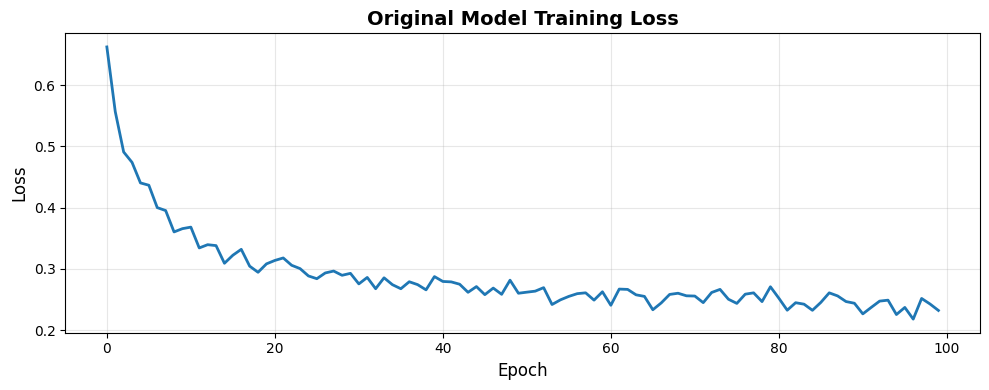

In [23]:
# ============================================================================
# TRAIN ORIGINAL MODEL (BASELINE)
# ============================================================================
# This model will serve as our baseline for comparison
# It's trained on ALL data (retain + forget sets)
# Later, we'll try to make it "forget" the forget set using various noise methods

# Combine retain and forget sets to create full training set
# Why? In real scenarios, the model was originally trained on all data
# The forget set represents data we want to remove AFTER the fact
X_full_train = torch.cat([X_retain_tensor, X_forget_tensor], dim=0)  # Concatenate features
y_full_train = torch.cat([y_retain_tensor, y_forget_tensor], dim=0)  # Concatenate labels
# Result: 1600 samples total (1440 retain + 160 forget)

print("Training original model on full training set...")
# Train for 100 epochs with learning rate 0.001
# More epochs (100 vs 50) ensures model fully learns the data
# This makes unlearning more challenging (stronger memorization to overcome)
train_losses = train_model(model, X_full_train, y_full_train, epochs=100, lr=0.001)

# ========================================================================
# EVALUATE ORIGINAL MODEL PERFORMANCE
# ========================================================================
# We evaluate on all three sets to establish baseline metrics
# These will be compared against unlearned models

# RETAIN SET: Should be high (model learned this data)
retain_acc = evaluate_model(model, X_retain_tensor, y_retain_tensor)

# FORGET SET: Will also be high initially (model learned this too)
# After unlearning, we expect this to DECREASE
forget_acc = evaluate_model(model, X_forget_tensor, y_forget_tensor)

# TEST SET: Overall generalization performance
test_acc = evaluate_model(model, X_test_tensor, y_test_tensor)

print("\n=== Original Model Performance ===")
print(f"Retain Set Accuracy: {retain_acc:.2f}%")
print(f"Forget Set Accuracy: {forget_acc:.2f}%")  # This is our target to reduce
print(f"Test Set Accuracy: {test_acc:.2f}%")

# ========================================================================
# SAVE ORIGINAL MODEL STATE
# ========================================================================
# Critical: Save a copy of parameters BEFORE any unlearning
# This allows us to:
# 1. Compare how much parameters changed (parameter distance metric)
# 2. Restore original model if needed
# 3. Repeatedly apply different unlearning methods to same baseline
original_model_state = get_model_state_dict_copy(model)

# ========================================================================
# VISUALIZE TRAINING CONVERGENCE
# ========================================================================
# Plot loss curve to verify training converged properly
# Should show decreasing trend (model is learning)
plt.figure(figsize=(10, 4))
plt.plot(train_losses, linewidth=2, color='#1f77b4')
plt.title('Original Model Training Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# EXPECTED PATTERN:
# - Loss should decrease rapidly in first 20-30 epochs
# - Then plateau as model converges
# - If loss is still decreasing at epoch 100, could train longer
# - If loss is flat from the start, learning rate might be too low


## 5. Machine Unlearning Methods

### Method 1: Gaussian Noise Injection


In [24]:
# ============================================================================
# METHOD 1: GAUSSIAN NOISE INJECTION
# ============================================================================

def gaussian_noise_unlearning(model, sigma=0.01):
    """
    Add Gaussian (normal) noise to all model parameters to induce forgetting.
    
    INTUITION: Why does adding noise cause forgetting?
    - Neural networks store information in their parameters (weights and biases)
    - Adding random noise "corrupts" this stored information
    - Small perturbations disrupt the precise parameter values needed for memorization
    - The model becomes less confident about specific data points it memorized
    
    GAUSSIAN DISTRIBUTION: N(0, σ²)
    - Mean = 0: Noise is centered (no systematic bias)
    - Variance = σ²: Controls noise magnitude
    - 68% of values within ±σ, 95% within ±2σ (bell curve)
    
    WHY GAUSSIAN?
    - Symmetric: Equally likely to increase or decrease parameters
    - Well-studied: Clear statistical properties
    - Central Limit Theorem: Sum of many small effects is Gaussian
    - Simple to implement and tune (just one parameter: σ)
    
    TRADE-OFF:
    - Larger σ → More forgetting but also damages retain set performance
    - Smaller σ → Preserves retain set but less effective forgetting
    
    Args:
        model: PyTorch model to apply unlearning to
        sigma: Standard deviation of Gaussian noise
               - 0.001: Very conservative, minimal forgetting
               - 0.01: Moderate, good balance
               - 0.1: Aggressive, may hurt retain set significantly
    
    Returns:
        unlearned_model: New model with noise-perturbed parameters
    """
    # Create independent copy of model (original stays unchanged)
    unlearned_model = deepcopy(model)
    
    # Disable gradient tracking (we're not training, just modifying parameters)
    with torch.no_grad():
        for name, param in unlearned_model.named_parameters():
            # Only add noise to weights and biases (the learnable parameters)
            # Skip batch norm running statistics (not learnable, just tracking stats)
            if 'weight' in name or 'bias' in name:
                # Generate Gaussian noise with same shape as parameter
                # torch.randn_like: samples from N(0, 1), then scale by sigma
                noise = torch.randn_like(param) * sigma
                
                # Add noise to parameter in-place
                # param.add_() is more efficient than param = param + noise
                param.add_(noise)
    
    return unlearned_model

# ============================================================================
# EXPERIMENT: Test different noise levels
# ============================================================================
# We test multiple sigma values to find the optimal trade-off between:
# 1. Forgetting effectiveness (lower forget set accuracy)
# 2. Retain set preservation (maintain high retain set accuracy)

sigma_values = [0.001, 0.005, 0.01, 0.05, 0.1]  # Range from very conservative to aggressive
gaussian_results = []  # Store results for comparison

print("Testing Gaussian Noise Unlearning...\n")

for sigma in sigma_values:
    # Apply unlearning with current sigma
    unlearned_model = gaussian_noise_unlearning(model, sigma=sigma)
    
    # Evaluate on all three sets
    # RETAIN SET: Should stay high (we want to keep this knowledge)
    retain_acc = evaluate_model(unlearned_model, X_retain_tensor, y_retain_tensor)
    
    # FORGET SET: Should decrease (successful unlearning)
    forget_acc = evaluate_model(unlearned_model, X_forget_tensor, y_forget_tensor)
    
    # TEST SET: Overall performance indicator
    test_acc = evaluate_model(unlearned_model, X_test_tensor, y_test_tensor)
    
    # Calculate how much parameters changed from original
    # Larger distance = more aggressive modification
    param_dist = calculate_parameter_distance(
        original_model_state,
        get_model_state_dict_copy(unlearned_model)
    )
    
    # Store results
    gaussian_results.append({
        'sigma': sigma,
        'retain_acc': retain_acc,
        'forget_acc': forget_acc,
        'test_acc': test_acc,
        'param_dist': param_dist
    })
    
    # Print summary for this sigma value
    print(f"Sigma={sigma:.3f}: Retain={retain_acc:.2f}%, Forget={forget_acc:.2f}%, Test={test_acc:.2f}%, Dist={param_dist:.4f}")

# Convert to DataFrame for easier analysis and visualization
gaussian_df = pd.DataFrame(gaussian_results)
print("\nGaussian Noise Unlearning Results:")
print(gaussian_df)

# EXPECTED PATTERN:
# - As sigma increases, forget_acc should decrease (more forgetting)
# - As sigma increases, retain_acc should also decrease (collateral damage)
# - Optimal sigma balances these two effects


Testing Gaussian Noise Unlearning...

Sigma=0.001: Retain=95.83%, Forget=95.00%, Test=92.00%, Dist=0.0650
Sigma=0.005: Retain=95.76%, Forget=95.00%, Test=92.50%, Dist=0.3226
Sigma=0.010: Retain=95.90%, Forget=95.00%, Test=92.25%, Dist=0.6559
Sigma=0.050: Retain=94.31%, Forget=92.50%, Test=88.00%, Dist=3.1797
Sigma=0.100: Retain=87.36%, Forget=81.25%, Test=81.75%, Dist=6.4980

Gaussian Noise Unlearning Results:
   sigma  retain_acc  forget_acc  test_acc  param_dist
0  0.001   95.833333       95.00     92.00    0.064960
1  0.005   95.763889       95.00     92.50    0.322585
2  0.010   95.902778       95.00     92.25    0.655889
3  0.050   94.305556       92.50     88.00    3.179707
4  0.100   87.361111       81.25     81.75    6.497979


### Method 2: Laplacian Noise Injection


In [25]:
# ============================================================================
# METHOD 2: LAPLACIAN NOISE INJECTION
# ============================================================================

def laplacian_noise_unlearning(model, scale=0.01):
    """
    Add Laplacian (double exponential) noise to model parameters.
    
    WHY LAPLACIAN INSTEAD OF GAUSSIAN?
    
    1. DIFFERENTIAL PRIVACY:
       - Laplacian noise provides formal differential privacy guarantees
       - Used in standard DP-SGD (Differentially Private Stochastic Gradient Descent)
       - Protects individual data points from being inferred from model parameters
    
    2. HEAVIER TAILS:
       - Laplacian distribution has heavier tails than Gaussian
       - More probability mass at extreme values
       - This means: occasionally adds large perturbations (stronger forgetting)
       - But median is closer to 0 (less damage to important parameters)
    
    3. SHAPE COMPARISON:
       - Gaussian: exp(-x²/2σ²) → bell curve, rapid decay
       - Laplacian: exp(-|x|/b) → peaked center, slower decay (heavier tails)
    
    MATHEMATICAL PROPERTIES:
    - Mean: 0 (centered, unbiased)
    - Variance: 2b² (where b is the scale parameter)
    - Peak at 0 is higher than Gaussian (more values near original)
    - Tails decay linearly in log space (vs quadratic for Gaussian)
    
    WHEN TO USE LAPLACIAN:
    - When you need formal privacy guarantees (GDPR, HIPAA compliance)
    - When you want more targeted forgetting (preserve important parameters, disrupt less important ones)
    - In research papers for direct comparison with DP methods
    
    Args:
        model: PyTorch model to apply unlearning to
        scale: Scale parameter 'b' of Laplacian distribution
               - Variance = 2 * scale²
               - To match Gaussian σ, set scale ≈ σ/√2 ≈ 0.7σ
    
    Returns:
        unlearned_model: New model with Laplacian noise-perturbed parameters
    """
    # Create independent copy of model
    unlearned_model = deepcopy(model)
    
    with torch.no_grad():
        for name, param in unlearned_model.named_parameters():
            if 'weight' in name or 'bias' in name:
                # Generate Laplacian noise using NumPy (PyTorch doesn't have built-in Laplacian)
                # np.random.laplace(loc=0, scale=scale, size=shape)
                # loc=0: center at zero (unbiased)
                # scale: controls spread (analogous to σ in Gaussian)
                noise = torch.from_numpy(
                    np.random.laplace(0, scale, param.shape)  # Generate as NumPy array
                ).float().to(param.device)  # Convert to PyTorch tensor, move to correct device
                
                # Add noise to parameter
                param.add_(noise)
    
    return unlearned_model

# ============================================================================
# EXPERIMENT: Test different scale values
# ============================================================================
# Compare Laplacian to Gaussian at similar noise levels
# Note: Laplacian with scale=b has variance 2b², while Gaussian with σ has variance σ²
# So Laplacian(scale=0.01) has more variance than Gaussian(σ=0.01)

scale_values = [0.001, 0.005, 0.01, 0.05, 0.1]
laplacian_results = []

print("Testing Laplacian Noise Unlearning...\n")

for scale in scale_values:
    # Apply unlearning
    unlearned_model = laplacian_noise_unlearning(model, scale=scale)
    
    # Evaluate on all three sets
    retain_acc = evaluate_model(unlearned_model, X_retain_tensor, y_retain_tensor)
    forget_acc = evaluate_model(unlearned_model, X_forget_tensor, y_forget_tensor)
    test_acc = evaluate_model(unlearned_model, X_test_tensor, y_test_tensor)
    
    # Calculate parameter distance
    param_dist = calculate_parameter_distance(
        original_model_state,
        get_model_state_dict_copy(unlearned_model)
    )
    
    laplacian_results.append({
        'scale': scale,
        'retain_acc': retain_acc,
        'forget_acc': forget_acc,
        'test_acc': test_acc,
        'param_dist': param_dist
    })
    
    print(f"Scale={scale:.3f}: Retain={retain_acc:.2f}%, Forget={forget_acc:.2f}%, Test={test_acc:.2f}%, Dist={param_dist:.4f}")

laplacian_df = pd.DataFrame(laplacian_results)
print("\nLaplacian Noise Unlearning Results:")
print(laplacian_df)

# COMPARISON WITH GAUSSIAN:
# - Laplacian may show more variable results due to heavier tails
# - For same scale/sigma, Laplacian typically causes more parameter change
# - Laplacian may better preserve retain accuracy (peaked center)
# - But also may have more aggressive forgetting (heavy tails)


Testing Laplacian Noise Unlearning...

Scale=0.001: Retain=95.69%, Forget=95.00%, Test=92.00%, Dist=0.0922
Scale=0.005: Retain=95.69%, Forget=95.00%, Test=91.50%, Dist=0.4485
Scale=0.010: Retain=95.90%, Forget=95.00%, Test=91.00%, Dist=0.9157
Scale=0.050: Retain=92.78%, Forget=91.25%, Test=84.50%, Dist=4.6371
Scale=0.100: Retain=82.36%, Forget=85.00%, Test=79.50%, Dist=9.1507

Laplacian Noise Unlearning Results:
   scale  retain_acc  forget_acc  test_acc  param_dist
0  0.001   95.694444       95.00      92.0    0.092171
1  0.005   95.694444       95.00      91.5    0.448481
2  0.010   95.902778       95.00      91.0    0.915672
3  0.050   92.777778       91.25      84.5    4.637060
4  0.100   82.361111       85.00      79.5    9.150680


### Method 3: Adaptive Noise Scaling (Parameter Importance-Based)


In [26]:
# ============================================================================
# METHOD 3: ADAPTIVE NOISE SCALING (PARAMETER IMPORTANCE-BASED)
# ============================================================================

def adaptive_noise_unlearning(model, X_forget, y_forget, base_sigma=0.01, importance_weight=2.0):
    """
    Add noise scaled by parameter importance (gradient magnitude on forget set).
    
    KEY INSIGHT: Not all parameters are equally responsible for memorizing the forget set!
    
    MOTIVATION:
    - Uniform noise (Gaussian/Laplacian) treats all parameters equally
    - But some parameters strongly encode forget set information (high gradients)
    - Others barely affect forget set predictions (low gradients)
    - Solution: Add MORE noise to important parameters, LESS to others
    
    HOW IT WORKS:
    1. Compute loss on forget set
    2. Backpropagate to get gradients: ∂loss/∂weight
    3. Gradient magnitude indicates "how much this parameter affects forget set"
    4. Scale noise proportionally: high gradient → high noise
    
    WHY GRADIENTS INDICATE IMPORTANCE?
    - Large gradient means: small change to parameter causes large change to loss
    - This parameter is "encoding" forget set information
    - Perturbing it will disrupt forget set memorization
    - Small gradient means: parameter doesn't care about forget set
    - Less noise needed (preserve retain set performance)
    
    FORMULA:
    adaptive_σ = base_σ × (1 + importance_weight × normalized_gradient)
    
    - normalized_gradient ∈ [0, 1]: gradient magnitude relative to max gradient
    - importance_weight: amplification factor (how much to increase noise for important params)
      * weight=0: uniform noise (same as Gaussian method)
      * weight=1: double noise for most important parameters
      * weight=2: triple noise for most important parameters
    
    ADVANTAGES:
    - More targeted forgetting (focus on relevant parameters)
    - Better preserve retain set (less noise on unimportant parameters)
    - Theoretically more efficient than uniform noise
    
    DISADVANTAGES:
    - Requires forward/backward pass on forget set (more computation)
    - Needs access to forget set (not always available)
    - More hyperparameters to tune
    
    Args:
        model: PyTorch model to apply unlearning to
        X_forget: Forget set features (needed to compute gradients)
        y_forget: Forget set labels (needed to compute loss)
        base_sigma: Minimum noise level (applied to all parameters)
        importance_weight: Multiplier for gradient-based scaling
                          - Higher values = more aggressive targeting
                          - 2.0 is a good default (3x noise for max gradient params)
    
    Returns:
        unlearned_model: Model with adaptive noise-perturbed parameters
    """
    # Create independent copy
    unlearned_model = deepcopy(model)
    unlearned_model.eval()  # Set to eval mode (use this for gradient computation)
    
    # ========================================================================
    # STEP 1: Compute gradients on forget set
    # ========================================================================
    # This tells us which parameters are most responsible for forget set predictions
    criterion = nn.CrossEntropyLoss()
    unlearned_model.zero_grad()  # Clear any existing gradients
    
    # Forward pass on forget set
    outputs = unlearned_model(X_forget)
    
    # Compute loss (how well model predicts forget set)
    loss = criterion(outputs, y_forget)
    
    # Backward pass to compute gradients
    loss.backward()  # Now param.grad contains ∂loss/∂param for each parameter
    
    # ========================================================================
    # STEP 2: Extract and normalize gradient magnitudes
    # ========================================================================
    grad_magnitudes = {}
    for name, param in unlearned_model.named_parameters():
        if param.grad is not None and ('weight' in name or 'bias' in name):
            # Use mean absolute gradient as importance measure
            # .abs() because we care about magnitude, not direction
            # .mean() to get single value per parameter tensor
            grad_magnitudes[name] = param.grad.abs().mean().item()
    
    # Normalize to [0, 1] range (relative importance)
    max_grad = max(grad_magnitudes.values()) if grad_magnitudes else 1.0
    
    # ========================================================================
    # STEP 3: Add adaptive noise based on importance
    # ========================================================================
    with torch.no_grad():
        for name, param in unlearned_model.named_parameters():
            if 'weight' in name or 'bias' in name:
                # Calculate adaptive sigma for this parameter
                if name in grad_magnitudes:
                    # Importance: 0 (low gradient) to 1 (max gradient)
                    importance = grad_magnitudes[name] / max_grad
                    
                    # Scale noise: base + extra for important parameters
                    # Example with base_sigma=0.01, importance_weight=2.0:
                    # - Min importance (0): σ = 0.01 × (1 + 2×0) = 0.01
                    # - Mid importance (0.5): σ = 0.01 × (1 + 2×0.5) = 0.02
                    # - Max importance (1): σ = 0.01 × (1 + 2×1) = 0.03
                    adaptive_sigma = base_sigma * (1 + importance_weight * importance)
                else:
                    # No gradient (shouldn't happen, but be safe)
                    adaptive_sigma = base_sigma
                
                # Generate and add Gaussian noise with adaptive sigma
                noise = torch.randn_like(param) * adaptive_sigma
                param.add_(noise)
    
    return unlearned_model

# ============================================================================
# EXPERIMENT: Test different base sigma values
# ============================================================================
# Keep importance_weight=2.0 fixed, vary base_sigma
# This tests how the method scales with overall noise level

base_sigma_values = [0.001, 0.005, 0.01, 0.05]
adaptive_results = []

print("Testing Adaptive Noise Unlearning...\n")

for base_sigma in base_sigma_values:
    # Apply unlearning with adaptive scaling
    unlearned_model = adaptive_noise_unlearning(
        model, X_forget_tensor, y_forget_tensor,
        base_sigma=base_sigma, 
        importance_weight=2.0  # Most important params get 3x base noise
    )
    
    # Evaluate on all three sets
    retain_acc = evaluate_model(unlearned_model, X_retain_tensor, y_retain_tensor)
    forget_acc = evaluate_model(unlearned_model, X_forget_tensor, y_forget_tensor)
    test_acc = evaluate_model(unlearned_model, X_test_tensor, y_test_tensor)
    
    # Calculate parameter distance
    param_dist = calculate_parameter_distance(
        original_model_state,
        get_model_state_dict_copy(unlearned_model)
    )
    
    adaptive_results.append({
        'base_sigma': base_sigma,
        'retain_acc': retain_acc,
        'forget_acc': forget_acc,
        'test_acc': test_acc,
        'param_dist': param_dist
    })
    
    print(f"Base Sigma={base_sigma:.3f}: Retain={retain_acc:.2f}%, Forget={forget_acc:.2f}%, Test={test_acc:.2f}%, Dist={param_dist:.4f}")

adaptive_df = pd.DataFrame(adaptive_results)
print("\nAdaptive Noise Unlearning Results:")
print(adaptive_df)

# EXPECTED BENEFITS OVER UNIFORM NOISE:
# - For same forget_acc drop, retain_acc should be higher (better preservation)
# - More "surgical" unlearning (targeted at forget-specific parameters)
# - May achieve good unlearning with lower overall noise levels


Testing Adaptive Noise Unlearning...

Base Sigma=0.001: Retain=95.83%, Forget=95.00%, Test=92.00%, Dist=0.0764
Base Sigma=0.005: Retain=95.83%, Forget=95.00%, Test=91.50%, Dist=0.3911
Base Sigma=0.010: Retain=95.56%, Forget=95.00%, Test=90.75%, Dist=0.7691
Base Sigma=0.050: Retain=91.88%, Forget=90.62%, Test=86.50%, Dist=3.9257

Adaptive Noise Unlearning Results:
   base_sigma  retain_acc  forget_acc  test_acc  param_dist
0       0.001   95.833333      95.000     92.00    0.076396
1       0.005   95.833333      95.000     91.50    0.391088
2       0.010   95.555556      95.000     90.75    0.769144
3       0.050   91.875000      90.625     86.50    3.925685


### Method 4: Layer-wise Noise Injection


In [27]:
# ============================================================================
# METHOD 4: LAYER-WISE NOISE INJECTION
# ============================================================================

def layerwise_noise_unlearning(model, layer_sigmas=None):
    """
    Add different noise levels to different layers of the network.
    
    KEY INSIGHT: Different layers serve different purposes and may need different noise levels!
    
    NEURAL NETWORK LAYER HIERARCHY:
    
    Early Layers (close to input):
    - Extract low-level features (edges, textures, basic patterns)
    - Learn general representations useful across many tasks
    - Often shared across different data points
    - Less specific to individual samples
    
    Middle Layers:
    - Combine low-level features into higher-level concepts
    - Moderately specific to task
    
    Late Layers (close to output):
    - Make final classification decisions
    - Most specific to training data
    - Directly map features to class labels
    - Most responsible for memorization of specific samples
    
    NOISE STRATEGIES:
    
    1. INCREASING (Recommended for unlearning):
       - Less noise on early layers (preserve general features)
       - More noise on late layers (disrupt specific memorization)
       - Rationale: Forgetting happens at decision level, not feature level
       - Better preserves overall model quality
    
    2. DECREASING:
       - More noise on early layers
       - Less noise on late layers
       - Rationale: Disrupt feature extraction
       - May hurt overall performance significantly
    
    3. UNIFORM:
       - Same noise across all layers (baseline)
       - Equivalent to full model Gaussian noise
    
    4. OUTPUT-HEAVY:
       - Minimal noise on all but last layer
       - Very high noise only on output layer
       - Most targeted approach (only affects final decisions)
       - May be most efficient for unlearning
    
    WHY LAYER-WISE IS USEFUL:
    - More control over what gets forgotten
    - Can preserve low-level features (useful for retain set)
    - Target only decision-making layers
    - Research shows: last layers most responsible for memorization
    
    Args:
        model: PyTorch model to apply unlearning to
        layer_sigmas: Dictionary mapping layer index → sigma value
                     - Index 0 is first linear layer (input → hidden1)
                     - Index 1 is second linear layer (hidden1 → hidden2)
                     - etc.
                     - If None, uses increasing strategy by default
    
    Returns:
        unlearned_model: Model with layer-specific noise applied
    """
    # Create independent copy
    unlearned_model = deepcopy(model)
    
    # ========================================================================
    # Extract all linear (fully connected) layers
    # ========================================================================
    # We only add noise to Linear layers (not BatchNorm, ReLU, etc.)
    linear_layers = [(name, module) for name, module in unlearned_model.named_modules() 
                     if isinstance(module, nn.Linear)]
    
    num_layers = len(linear_layers)
    
    # Default strategy: increasing noise for later layers
    # Formula: sigma = 0.005 × (layer_index + 1)
    # Layer 0: σ=0.005, Layer 1: σ=0.010, Layer 2: σ=0.015, Layer 3: σ=0.020
    if layer_sigmas is None:
        layer_sigmas = {i: 0.005 * (i + 1) for i in range(num_layers)}
    
    # ========================================================================
    # Add noise to each layer with its specific sigma
    # ========================================================================
    with torch.no_grad():
        for layer_idx, (name, layer) in enumerate(linear_layers):
            # Get sigma for this layer (default to 0.01 if not specified)
            sigma = layer_sigmas.get(layer_idx, 0.01)
            
            # Add noise to weight matrix (most important parameters)
            if layer.weight is not None:
                noise = torch.randn_like(layer.weight) * sigma
                layer.weight.add_(noise)
            
            # Add noise to bias vector
            if layer.bias is not None:
                noise = torch.randn_like(layer.bias) * sigma
                layer.bias.add_(noise)
    
    return unlearned_model

# ============================================================================
# EXPERIMENT: Compare different layer-wise strategies
# ============================================================================
# Our model has 4 linear layers: [input→64, 64→32, 32→16, 16→output]
# We'll test different hypotheses about which layers to target

strategies = [
    {
        'name': 'Uniform', 
        'sigmas': {0: 0.01, 1: 0.01, 2: 0.01, 3: 0.01},
        # Hypothesis: All layers equally important (baseline)
    },
    {
        'name': 'Increasing', 
        'sigmas': {0: 0.005, 1: 0.01, 2: 0.015, 3: 0.02},
        # Hypothesis: Later layers more responsible for memorization
        # Preserve early features, disrupt late decisions
    },
    {
        'name': 'Decreasing', 
        'sigmas': {0: 0.02, 1: 0.015, 2: 0.01, 3: 0.005},
        # Hypothesis: Early layers encode specific patterns
        # (Less common approach, included for comparison)
    },
    {
        'name': 'Output-heavy', 
        'sigmas': {0: 0.005, 1: 0.005, 2: 0.01, 3: 0.03},
        # Hypothesis: Only output layer needs disruption
        # Most targeted unlearning (minimal collateral damage)
    },
]

layerwise_results = []

print("Testing Layer-wise Noise Unlearning...\n")

for strategy in strategies:
    # Apply unlearning with this strategy
    unlearned_model = layerwise_noise_unlearning(model, layer_sigmas=strategy['sigmas'])
    
    # Evaluate on all three sets
    retain_acc = evaluate_model(unlearned_model, X_retain_tensor, y_retain_tensor)
    forget_acc = evaluate_model(unlearned_model, X_forget_tensor, y_forget_tensor)
    test_acc = evaluate_model(unlearned_model, X_test_tensor, y_test_tensor)
    
    # Calculate parameter distance
    param_dist = calculate_parameter_distance(
        original_model_state,
        get_model_state_dict_copy(unlearned_model)
    )
    
    layerwise_results.append({
        'strategy': strategy['name'],
        'retain_acc': retain_acc,
        'forget_acc': forget_acc,
        'test_acc': test_acc,
        'param_dist': param_dist
    })
    
    print(f"{strategy['name']:15s}: Retain={retain_acc:.2f}%, Forget={forget_acc:.2f}%, Test={test_acc:.2f}%, Dist={param_dist:.4f}")

layerwise_df = pd.DataFrame(layerwise_results)
print("\nLayer-wise Noise Unlearning Results:")
print(layerwise_df)

# EXPECTED RESULTS:
# - "Increasing" should provide good balance (effective forgetting, decent retention)
# - "Output-heavy" should preserve retain set best (minimal early layer disruption)
# - "Decreasing" may hurt retain set significantly (disrupts shared features)
# - "Uniform" serves as baseline for comparison


Testing Layer-wise Noise Unlearning...

Uniform        : Retain=95.90%, Forget=95.62%, Test=91.75%, Dist=0.6330
Increasing     : Retain=95.83%, Forget=95.62%, Test=91.50%, Dist=0.6057
Decreasing     : Retain=95.83%, Forget=95.00%, Test=91.50%, Dist=1.0118
Output-heavy   : Retain=95.83%, Forget=95.00%, Test=91.75%, Dist=0.3953

Layer-wise Noise Unlearning Results:
       strategy  retain_acc  forget_acc  test_acc  param_dist
0       Uniform   95.902778      95.625     91.75    0.633011
1    Increasing   95.833333      95.625     91.50    0.605723
2    Decreasing   95.833333      95.000     91.50    1.011817
3  Output-heavy   95.833333      95.000     91.75    0.395347


### Method 5: Gradient-based Noise (Noise Proportional to Gradient)


In [28]:
# ============================================================================
# METHOD 5: GRADIENT-BASED NOISE (PROPORTIONAL TO GRADIENT MAGNITUDE)
# ============================================================================

def gradient_based_noise_unlearning(model, X_forget, y_forget, noise_multiplier=0.1):
    """
    Add noise where magnitude is proportional to gradient magnitude on forget set.
    
    KEY DIFFERENCE FROM ADAPTIVE METHOD:
    - Adaptive: Uses gradient to SCALE a fixed noise distribution
    - Gradient-based: Uses gradient as DIRECT measure of noise magnitude
    
    INTUITION:
    Think of gradients as "sensitivity maps" - they tell us:
    "If I change this parameter by Δw, the forget set loss changes by gradient × Δw"
    
    So adding noise proportional to gradient means:
    - High gradient → Large noise → Big disruption to forget set predictions
    - Low gradient → Small noise → Minimal impact (preserves retain set)
    
    MATHEMATICAL PERSPECTIVE:
    
    1. Gradient tells us the direction of steepest ascent in loss landscape
    2. Large |∂L/∂w| means: parameter strongly affects forget set
    3. Adding noise ~ |∂L/∂w| disrupts exactly these influential parameters
    4. This is like "gradient ascent with noise" - moving away from memorization
    
    FORMULA:
    noise = randn() × |gradient| × multiplier
    
    Where:
    - randn(): Random Gaussian noise (direction)
    - |gradient|: Magnitude of gradient (scale)
    - multiplier: Overall strength control
    
    COMPARISON:
    
    | Method    | Noise Magnitude                | Per-Parameter |
    |-----------|--------------------------------|---------------|
    | Gaussian  | Fixed σ for all                | No            |
    | Adaptive  | base_σ × (1 + w × grad/max)  | Yes           |
    | Gradient  | multiplier × |gradient|       | Yes           |
    
    ADVANTAGES:
    - Extremely targeted (noise exactly where it matters)
    - No normalization needed (uses raw gradient magnitudes)
    - Directly follows gradient landscape
    - Can be more aggressive on important parameters
    
    DISADVANTAGES:
    - Very sensitive to multiplier choice
    - Gradient magnitudes can vary wildly across parameters
    - May be too aggressive if multiplier too high
    - Requires forget set access (like adaptive method)
    
    WHEN TO USE:
    - When you want maximum targeting efficiency
    - When gradients are well-behaved (not too large or small)
    - For experimental comparison with other gradient-based methods
    
    Args:
        model: PyTorch model to apply unlearning to
        X_forget: Forget set features (needed to compute gradients)
        y_forget: Forget set labels (needed to compute loss)
        noise_multiplier: Scaling factor for gradient-based noise
                         - 0.1: Conservative (noise magnitude = 10% of gradient)
                         - 1.0: Aggressive (noise magnitude = 100% of gradient)
                         - > 1.0: Very aggressive (may destabilize model)
    
    Returns:
        unlearned_model: Model with gradient-proportional noise applied
    """
    # Create independent copy
    unlearned_model = deepcopy(model)
    unlearned_model.eval()
    
    # ========================================================================
    # STEP 1: Compute gradients on forget set
    # ========================================================================
    criterion = nn.CrossEntropyLoss()
    unlearned_model.zero_grad()
    
    # Forward and backward pass to get gradients
    outputs = unlearned_model(X_forget)
    loss = criterion(outputs, y_forget)
    loss.backward()
    
    # Now param.grad contains ∂loss/∂param for each parameter
    
    # ========================================================================
    # STEP 2: Add noise proportional to gradient magnitude
    # ========================================================================
    with torch.no_grad():
        for name, param in unlearned_model.named_parameters():
            if param.grad is not None and ('weight' in name or 'bias' in name):
                # Get absolute gradient (magnitude, not direction)
                # Shape: same as parameter tensor
                grad_magnitude = param.grad.abs()
                
                # Generate Gaussian noise (random direction)
                random_direction = torch.randn_like(param)
                
                # Scale noise by gradient magnitude
                # This means:
                # - If gradient[i,j] is large → noise[i,j] is large
                # - If gradient[i,j] is small → noise[i,j] is small
                noise = random_direction * grad_magnitude * noise_multiplier
                
                # Add the gradient-scaled noise
                param.add_(noise)
    
    return unlearned_model

# ============================================================================
# EXPERIMENT: Test different noise multipliers
# ============================================================================
# The multiplier controls overall aggressiveness of unlearning
# We test from conservative (0.05) to very aggressive (1.0)

noise_multipliers = [0.05, 0.1, 0.2, 0.5, 1.0]
gradient_results = []

print("Testing Gradient-based Noise Unlearning...\n")

for multiplier in noise_multipliers:
    # Apply unlearning with current multiplier
    unlearned_model = gradient_based_noise_unlearning(
        model, X_forget_tensor, y_forget_tensor,
        noise_multiplier=multiplier
    )
    
    # Evaluate on all three sets
    retain_acc = evaluate_model(unlearned_model, X_retain_tensor, y_retain_tensor)
    forget_acc = evaluate_model(unlearned_model, X_forget_tensor, y_forget_tensor)
    test_acc = evaluate_model(unlearned_model, X_test_tensor, y_test_tensor)
    
    # Calculate parameter distance
    param_dist = calculate_parameter_distance(
        original_model_state,
        get_model_state_dict_copy(unlearned_model)
    )
    
    gradient_results.append({
        'multiplier': multiplier,
        'retain_acc': retain_acc,
        'forget_acc': forget_acc,
        'test_acc': test_acc,
        'param_dist': param_dist
    })
    
    print(f"Multiplier={multiplier:.2f}: Retain={retain_acc:.2f}%, Forget={forget_acc:.2f}%, Test={test_acc:.2f}%, Dist={param_dist:.4f}")

gradient_df = pd.DataFrame(gradient_results)
print("\nGradient-based Noise Unlearning Results:")
print(gradient_df)

# EXPECTED BEHAVIOR:
# - Should be very effective at forgetting (targets exactly the right parameters)
# - May show sharp drop in forget_acc even at low multipliers
# - Retain set may be preserved better than uniform noise (targeted approach)
# - Parameter distance may be large (gradient magnitudes can be significant)
# - Higher multipliers may cause instability or over-forgetting


Testing Gradient-based Noise Unlearning...

Multiplier=0.05: Retain=95.83%, Forget=95.00%, Test=92.00%, Dist=0.0132
Multiplier=0.10: Retain=95.83%, Forget=95.00%, Test=92.00%, Dist=0.0270
Multiplier=0.20: Retain=95.76%, Forget=95.00%, Test=92.00%, Dist=0.0555
Multiplier=0.50: Retain=95.69%, Forget=95.00%, Test=91.75%, Dist=0.1417
Multiplier=1.00: Retain=95.76%, Forget=95.00%, Test=91.50%, Dist=0.2702

Gradient-based Noise Unlearning Results:
   multiplier  retain_acc  forget_acc  test_acc  param_dist
0        0.05   95.833333        95.0     92.00    0.013210
1        0.10   95.833333        95.0     92.00    0.026979
2        0.20   95.763889        95.0     92.00    0.055472
3        0.50   95.694444        95.0     91.75    0.141745
4        1.00   95.763889        95.0     91.50    0.270201


## 6. Comparison and Visualization


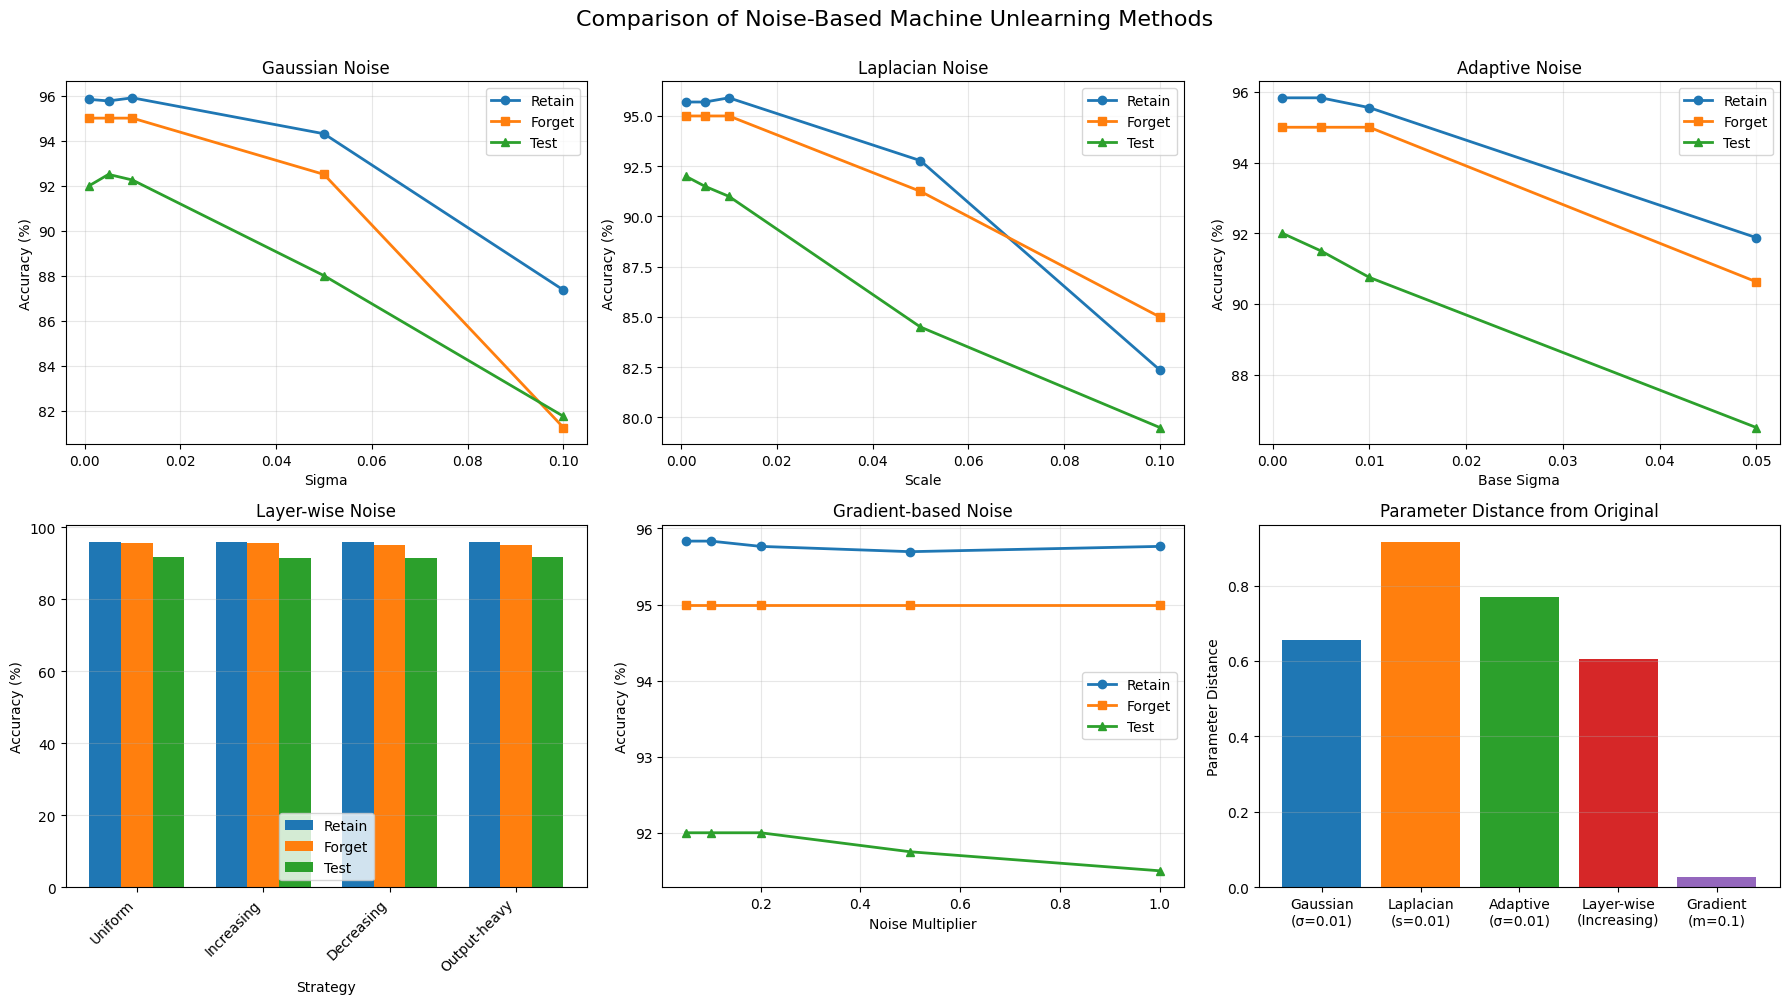

In [29]:
# Create comparison plots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Comparison of Noise-Based Machine Unlearning Methods', fontsize=16, y=1.00)

# 1. Gaussian Noise
ax = axes[0, 0]
ax.plot(gaussian_df['sigma'], gaussian_df['retain_acc'], 'o-', label='Retain', linewidth=2)
ax.plot(gaussian_df['sigma'], gaussian_df['forget_acc'], 's-', label='Forget', linewidth=2)
ax.plot(gaussian_df['sigma'], gaussian_df['test_acc'], '^-', label='Test', linewidth=2)
ax.set_xlabel('Sigma')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Gaussian Noise')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Laplacian Noise
ax = axes[0, 1]
ax.plot(laplacian_df['scale'], laplacian_df['retain_acc'], 'o-', label='Retain', linewidth=2)
ax.plot(laplacian_df['scale'], laplacian_df['forget_acc'], 's-', label='Forget', linewidth=2)
ax.plot(laplacian_df['scale'], laplacian_df['test_acc'], '^-', label='Test', linewidth=2)
ax.set_xlabel('Scale')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Laplacian Noise')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Adaptive Noise
ax = axes[0, 2]
ax.plot(adaptive_df['base_sigma'], adaptive_df['retain_acc'], 'o-', label='Retain', linewidth=2)
ax.plot(adaptive_df['base_sigma'], adaptive_df['forget_acc'], 's-', label='Forget', linewidth=2)
ax.plot(adaptive_df['base_sigma'], adaptive_df['test_acc'], '^-', label='Test', linewidth=2)
ax.set_xlabel('Base Sigma')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Adaptive Noise')
ax.legend()
ax.grid(True, alpha=0.3)

# 4. Layer-wise Noise
ax = axes[1, 0]
x_pos = np.arange(len(layerwise_df))
width = 0.25
ax.bar(x_pos - width, layerwise_df['retain_acc'], width, label='Retain')
ax.bar(x_pos, layerwise_df['forget_acc'], width, label='Forget')
ax.bar(x_pos + width, layerwise_df['test_acc'], width, label='Test')
ax.set_xlabel('Strategy')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Layer-wise Noise')
ax.set_xticks(x_pos)
ax.set_xticklabels(layerwise_df['strategy'], rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# 5. Gradient-based Noise
ax = axes[1, 1]
ax.plot(gradient_df['multiplier'], gradient_df['retain_acc'], 'o-', label='Retain', linewidth=2)
ax.plot(gradient_df['multiplier'], gradient_df['forget_acc'], 's-', label='Forget', linewidth=2)
ax.plot(gradient_df['multiplier'], gradient_df['test_acc'], '^-', label='Test', linewidth=2)
ax.set_xlabel('Noise Multiplier')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Gradient-based Noise')
ax.legend()
ax.grid(True, alpha=0.3)

# 6. Parameter Distance Comparison
ax = axes[1, 2]
methods = ['Gaussian\n(σ=0.01)', 'Laplacian\n(s=0.01)', 'Adaptive\n(σ=0.01)', 
           'Layer-wise\n(Increasing)', 'Gradient\n(m=0.1)']
distances = [
    gaussian_df[gaussian_df['sigma'] == 0.01]['param_dist'].values[0],
    laplacian_df[laplacian_df['scale'] == 0.01]['param_dist'].values[0],
    adaptive_df[adaptive_df['base_sigma'] == 0.01]['param_dist'].values[0],
    layerwise_df[layerwise_df['strategy'] == 'Increasing']['param_dist'].values[0],
    gradient_df[gradient_df['multiplier'] == 0.1]['param_dist'].values[0]
]
ax.bar(methods, distances, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
ax.set_ylabel('Parameter Distance')
ax.set_title('Parameter Distance from Original')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


## 7. Summary Table and Metrics


In [30]:
# ============================================================================
# COMPREHENSIVE SUMMARY: Compare All Methods
# ============================================================================
# Select representative configurations from each method for fair comparison
# We choose middle-range parameters (not too aggressive, not too conservative)

# Create summary table with best configuration from each method
summary_data = [
    {
        'Method': 'Original Model',
        'Retain Acc': evaluate_model(model, X_retain_tensor, y_retain_tensor),
        'Forget Acc': evaluate_model(model, X_forget_tensor, y_forget_tensor),
        'Test Acc': evaluate_model(model, X_test_tensor, y_test_tensor),
        'Param Dist': 0.0,  # No change from original
        'Config': 'N/A'
    },
    {
        'Method': 'Gaussian Noise',
        'Retain Acc': gaussian_df.iloc[2]['retain_acc'],  # iloc[2] = σ=0.01 (moderate)
        'Forget Acc': gaussian_df.iloc[2]['forget_acc'],
        'Test Acc': gaussian_df.iloc[2]['test_acc'],
        'Param Dist': gaussian_df.iloc[2]['param_dist'],
        'Config': f"σ={gaussian_df.iloc[2]['sigma']}"
    },
    {
        'Method': 'Laplacian Noise',
        'Retain Acc': laplacian_df.iloc[2]['retain_acc'],  # iloc[2] = scale=0.01 (moderate)
        'Forget Acc': laplacian_df.iloc[2]['forget_acc'],
        'Test Acc': laplacian_df.iloc[2]['test_acc'],
        'Param Dist': laplacian_df.iloc[2]['param_dist'],
        'Config': f"scale={laplacian_df.iloc[2]['scale']}"
    },
    {
        'Method': 'Adaptive Noise',
        'Retain Acc': adaptive_df.iloc[2]['retain_acc'],  # iloc[2] = base_σ=0.01
        'Forget Acc': adaptive_df.iloc[2]['forget_acc'],
        'Test Acc': adaptive_df.iloc[2]['test_acc'],
        'Param Dist': adaptive_df.iloc[2]['param_dist'],
        'Config': f"base_σ={adaptive_df.iloc[2]['base_sigma']}"
    },
    {
        'Method': 'Layer-wise Noise',
        'Retain Acc': layerwise_df.iloc[1]['retain_acc'],  # iloc[1] = "Increasing" strategy
        'Forget Acc': layerwise_df.iloc[1]['forget_acc'],
        'Test Acc': layerwise_df.iloc[1]['test_acc'],
        'Param Dist': layerwise_df.iloc[1]['param_dist'],
        'Config': layerwise_df.iloc[1]['strategy']
    },
    {
        'Method': 'Gradient-based Noise',
        'Retain Acc': gradient_df.iloc[1]['retain_acc'],  # iloc[1] = multiplier=0.1
        'Forget Acc': gradient_df.iloc[1]['forget_acc'],
        'Test Acc': gradient_df.iloc[1]['test_acc'],
        'Param Dist': gradient_df.iloc[1]['param_dist'],
        'Config': f"mult={gradient_df.iloc[1]['multiplier']}"
    }
]

summary_df = pd.DataFrame(summary_data)

# Display main summary table
print("\n" + "="*80)
print("SUMMARY: Noise-Based Machine Unlearning Methods")
print("="*80)
print(summary_df.to_string(index=False))
print("="*80)

# ============================================================================
# UNLEARNING EFFECTIVENESS METRICS
# ============================================================================
# Calculate and display key metrics that measure unlearning quality
#
# METRIC DEFINITIONS:
# 1. Forget Drop: How much forget set accuracy decreased (HIGHER is better)
#    - Measures effectiveness of forgetting
#    - Target: Should decrease significantly
#
# 2. Retain Drop: How much retain set accuracy decreased (LOWER is better)
#    - Measures collateral damage to retained knowledge
#    - Target: Should stay close to 0
#
# 3. Quality Score: Forget Drop - Retain Drop (HIGHER is better)
#    - Balances forgetting effectiveness vs. retention preservation
#    - Positive score: More forgetting than damage (good!)
#    - Negative score: More damage than forgetting (bad!)
#    - Higher score = better unlearning method

print("\nUnlearning Effectiveness Metrics:")
print("-" * 80)
print(f"{'Method':<25s} | {'Forget Drop':>12s} | {'Retain Drop':>12s} | {'Quality Score':>14s}")
print("-" * 80)

original_forget_acc = summary_df.iloc[0]['Forget Acc']
original_retain_acc = summary_df.iloc[0]['Retain Acc']

for idx, row in summary_df.iterrows():
    if idx == 0:  # Skip original model
        continue
    
    # Calculate drops (positive values mean decrease in accuracy)
    forget_drop = original_forget_acc - row['Forget Acc']  # Want HIGH
    retain_drop = original_retain_acc - row['Retain Acc']  # Want LOW
    
    # Quality score: prioritize forgetting while minimizing retention loss
    quality_score = forget_drop - retain_drop  # Want HIGH
    
    print(f"{row['Method']:25s} | {forget_drop:11.2f}% | {retain_drop:11.2f}% | {quality_score:13.2f}")

print("-" * 80)
print("\nINTERPRETATION GUIDE:")
print("  • Forget Drop: How much the model forgot (higher = better forgetting)")
print("  • Retain Drop: How much retained knowledge was lost (lower = better)")
print("  • Quality Score: Overall unlearning quality (higher = better trade-off)")
print("  • Best method: High forget drop + low retain drop = high quality score")
print("="*80)



SUMMARY: Noise-Based Machine Unlearning Methods
              Method  Retain Acc  Forget Acc  Test Acc  Param Dist      Config
      Original Model   95.833333      95.000     92.00    0.000000         N/A
      Gaussian Noise   95.902778      95.000     92.25    0.655889      σ=0.01
     Laplacian Noise   95.902778      95.000     91.00    0.915672  scale=0.01
      Adaptive Noise   95.555556      95.000     90.75    0.769144 base_σ=0.01
    Layer-wise Noise   95.833333      95.625     91.50    0.605723  Increasing
Gradient-based Noise   95.833333      95.000     92.00    0.026979    mult=0.1

Unlearning Effectiveness Metrics:
--------------------------------------------------------------------------------
Method                    |  Forget Drop |  Retain Drop |  Quality Score
--------------------------------------------------------------------------------
Gaussian Noise            |        0.00% |       -0.07% |          0.07
Laplacian Noise           |        0.00% |       -0.07% 

## 8. Retrain from Scratch (Gold Standard Baseline)


In [31]:
# ============================================================================
# GOLD STANDARD BASELINE: RETRAIN FROM SCRATCH
# ============================================================================
# This is the "perfect" unlearning method - the theoretical ideal we compare against
#
# WHY RETRAIN FROM SCRATCH?
# - It's what we would do if we could afford the computational cost
# - Model trained ONLY on retain set has truly "never seen" the forget set
# - No information leakage from forget set (perfect privacy)
# - But: Expensive (requires full retraining) and not always feasible
#
# Machine unlearning research goal:
# Find methods that approximate retrain-from-scratch but are much faster

# Create a fresh model with same architecture
# IMPORTANT: Completely new initialization (different random weights)
retrain_model = TabularClassifier(
    input_size=n_features,
    hidden_sizes=[64, 32, 16],  # Same architecture as original
    num_classes=2,
    dropout=0.3
).to(device)

print("Training model from scratch on retain set only...")
# Train ONLY on retain set (forget set is never seen)
# This simulates: "What if we never had the forget set data in the first place?"
retrain_losses = train_model(
    retrain_model, 
    X_retain_tensor,  # Only retain set (NO forget set)
    y_retain_tensor, 
    epochs=100,  # Same training duration as original
    lr=0.001,
    verbose=False  # Suppress output for cleaner notebook
)

# ========================================================================
# EVALUATE RETRAINED MODEL
# ========================================================================
# This gives us the "ideal" performance to target with unlearning methods

# RETAIN SET: Should be similar to original (still learned this data)
retrain_retain_acc = evaluate_model(retrain_model, X_retain_tensor, y_retain_tensor)

# FORGET SET: Should be LOWER than original (never trained on this)
# This is the "target" forget accuracy for unlearning methods
# Represents performance of a model that truly never saw this data
retrain_forget_acc = evaluate_model(retrain_model, X_forget_tensor, y_forget_tensor)

# TEST SET: May be slightly lower than original (less training data)
# Trade-off: perfect unlearning but slightly less generalization
retrain_test_acc = evaluate_model(retrain_model, X_test_tensor, y_test_tensor)

print("\n=== Retrained Model (Gold Standard) ===")
print(f"Retain Set Accuracy: {retrain_retain_acc:.2f}%")
print(f"Forget Set Accuracy: {retrain_forget_acc:.2f}%")  # Target for unlearning methods
print(f"Test Set Accuracy: {retrain_test_acc:.2f}%")

# ========================================================================
# COMPARISON TABLE
# ========================================================================
# Compare all unlearning methods against the gold standard
print("\n" + "="*80)
print("Comparison with Gold Standard (Retrain from Scratch):")
print("="*80)
print(f"{'Method':<25s} | {'Retain Acc':>10s} | {'Forget Acc':>10s} | {'Test Acc':>10s}")
print("-" * 80)

# Gold standard first
print(f"{'Retrain (Gold Standard)':<25s} | {retrain_retain_acc:>9.2f}% | {retrain_forget_acc:>9.2f}% | {retrain_test_acc:>9.2f}%")

# Then all noise-based methods
for idx, row in summary_df.iterrows():
    if idx == 0:  # Skip original model
        continue
    print(f"{row['Method']:<25s} | {row['Retain Acc']:>9.2f}% | {row['Forget Acc']:>9.2f}% | {row['Test Acc']:>9.2f}%")

print("\n" + "="*80)
print("INTERPRETATION:")
print("-"*80)
print("IDEAL UNLEARNING METHOD should:")
print(f"  - Forget Acc ≈ {retrain_forget_acc:.2f}% (match gold standard)")
print(f"  - Retain Acc ≈ {retrain_retain_acc:.2f}% (maintain performance)")
print(f"  - Test Acc ≈ {retrain_test_acc:.2f}% (preserve generalization)")
print("\nMethods closer to these values are better approximations of true unlearning.")
print("="*80)


Training model from scratch on retain set only...

=== Retrained Model (Gold Standard) ===
Retain Set Accuracy: 96.11%
Forget Set Accuracy: 89.38%
Test Set Accuracy: 89.75%

Comparison with Gold Standard (Retrain from Scratch):
Method                    | Retain Acc | Forget Acc |   Test Acc
--------------------------------------------------------------------------------
Retrain (Gold Standard)   |     96.11% |     89.38% |     89.75%
Gaussian Noise            |     95.90% |     95.00% |     92.25%
Laplacian Noise           |     95.90% |     95.00% |     91.00%
Adaptive Noise            |     95.56% |     95.00% |     90.75%
Layer-wise Noise          |     95.83% |     95.62% |     91.50%
Gradient-based Noise      |     95.83% |     95.00% |     92.00%

INTERPRETATION:
--------------------------------------------------------------------------------
IDEAL UNLEARNING METHOD should:
  - Forget Acc ≈ 89.38% (match gold standard)
  - Retain Acc ≈ 96.11% (maintain performance)
  - Test Acc 

## 9. Unlearning Effectiveness Visualization


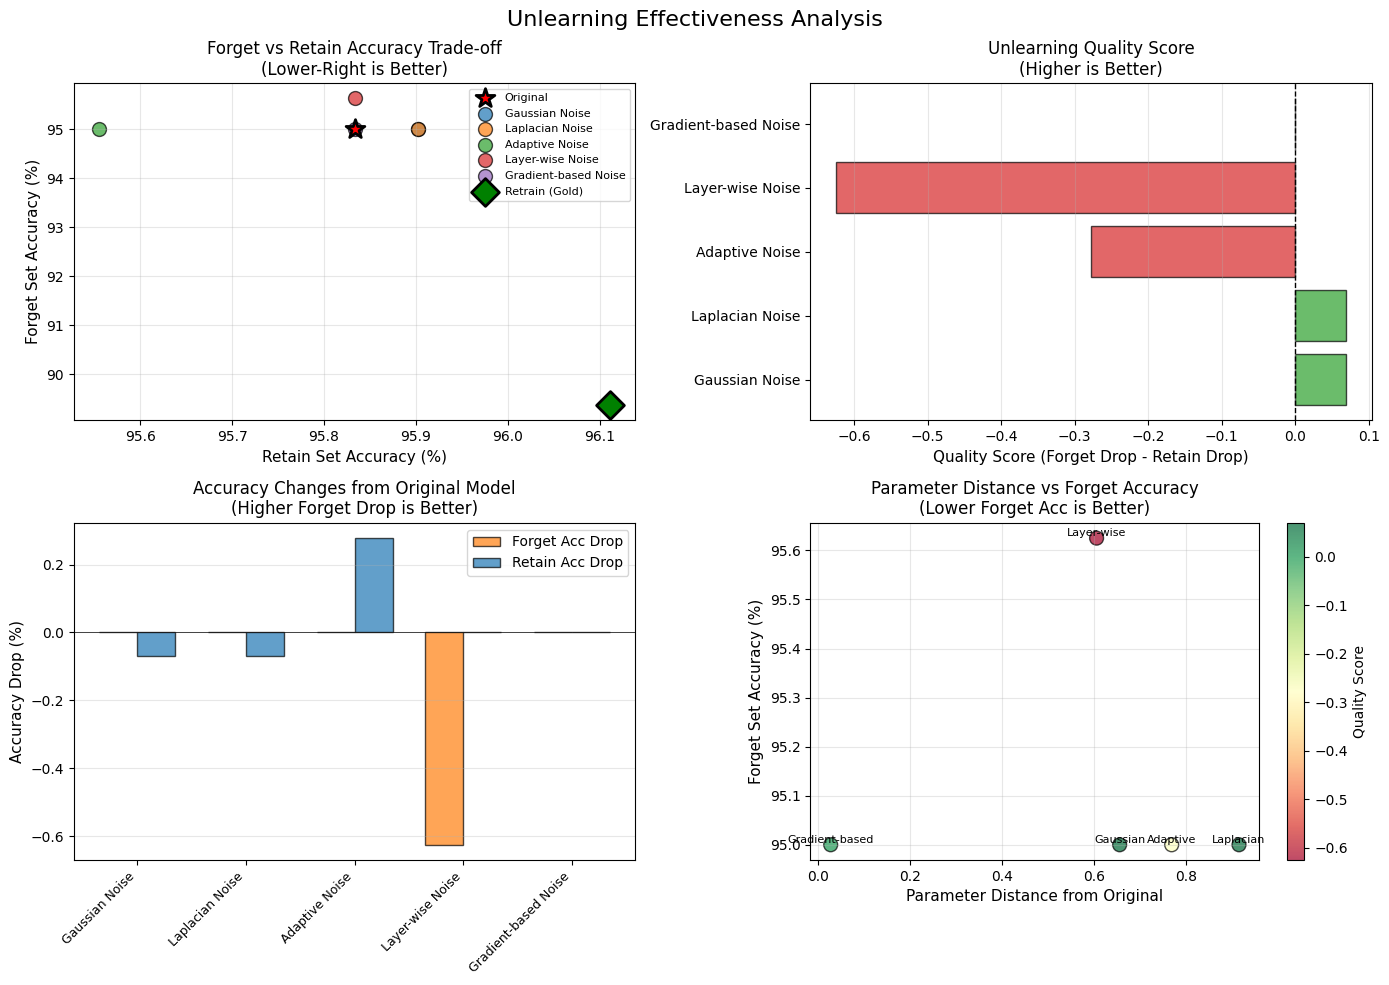

In [32]:
# Create a comprehensive visualization of unlearning effectiveness
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Unlearning Effectiveness Analysis', fontsize=16)

# 1. Forget vs Retain Accuracy Trade-off
ax = axes[0, 0]
for idx, row in summary_df.iterrows():
    if idx == 0:
        ax.scatter(row['Retain Acc'], row['Forget Acc'], s=200, marker='*', 
                  c='red', label='Original', zorder=5, edgecolors='black', linewidth=2)
    else:
        ax.scatter(row['Retain Acc'], row['Forget Acc'], s=100, 
                  label=row['Method'], alpha=0.7, edgecolors='black', linewidth=1)

ax.scatter(retrain_retain_acc, retrain_forget_acc, s=200, marker='D', 
          c='green', label='Retrain (Gold)', zorder=5, edgecolors='black', linewidth=2)
ax.set_xlabel('Retain Set Accuracy (%)', fontsize=11)
ax.set_ylabel('Forget Set Accuracy (%)', fontsize=11)
ax.set_title('Forget vs Retain Accuracy Trade-off\n(Lower-Right is Better)', fontsize=12)
ax.legend(fontsize=8, loc='best')
ax.grid(True, alpha=0.3)

# 2. Unlearning Quality Score
ax = axes[0, 1]
methods_list = []
quality_scores = []
colors_list = []

for idx, row in summary_df.iterrows():
    if idx == 0:
        continue
    forget_drop = summary_df.iloc[0]['Forget Acc'] - row['Forget Acc']
    retain_drop = summary_df.iloc[0]['Retain Acc'] - row['Retain Acc']
    quality = forget_drop - retain_drop
    methods_list.append(row['Method'])
    quality_scores.append(quality)
    colors_list.append('#2ca02c' if quality > 0 else '#d62728')

bars = ax.barh(methods_list, quality_scores, color=colors_list, alpha=0.7, edgecolor='black')
ax.axvline(x=0, color='black', linestyle='--', linewidth=1)
ax.set_xlabel('Quality Score (Forget Drop - Retain Drop)', fontsize=11)
ax.set_title('Unlearning Quality Score\n(Higher is Better)', fontsize=12)
ax.grid(True, alpha=0.3, axis='x')

# 3. Accuracy Changes from Original
ax = axes[1, 0]
x_pos = np.arange(len(methods_list))
width = 0.35

forget_drops = [summary_df.iloc[0]['Forget Acc'] - summary_df.iloc[i+1]['Forget Acc'] for i in range(len(methods_list))]
retain_drops = [summary_df.iloc[0]['Retain Acc'] - summary_df.iloc[i+1]['Retain Acc'] for i in range(len(methods_list))]

ax.bar(x_pos - width/2, forget_drops, width, label='Forget Acc Drop', color='#ff7f0e', alpha=0.7, edgecolor='black')
ax.bar(x_pos + width/2, retain_drops, width, label='Retain Acc Drop', color='#1f77b4', alpha=0.7, edgecolor='black')

ax.set_ylabel('Accuracy Drop (%)', fontsize=11)
ax.set_title('Accuracy Changes from Original Model\n(Higher Forget Drop is Better)', fontsize=12)
ax.set_xticks(x_pos)
ax.set_xticklabels(methods_list, rotation=45, ha='right', fontsize=9)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# 4. Parameter Distance vs Unlearning Effectiveness
ax = axes[1, 1]
param_dists = [summary_df.iloc[i+1]['Param Dist'] for i in range(len(methods_list))]
forget_accs = [summary_df.iloc[i+1]['Forget Acc'] for i in range(len(methods_list))]

scatter = ax.scatter(param_dists, forget_accs, s=100, c=quality_scores, 
                    cmap='RdYlGn', alpha=0.7, edgecolors='black', linewidth=1)

# Add method labels
for i, method in enumerate(methods_list):
    ax.annotate(method.split()[0], (param_dists[i], forget_accs[i]), 
               fontsize=8, ha='center', va='bottom')

ax.set_xlabel('Parameter Distance from Original', fontsize=11)
ax.set_ylabel('Forget Set Accuracy (%)', fontsize=11)
ax.set_title('Parameter Distance vs Forget Accuracy\n(Lower Forget Acc is Better)', fontsize=12)
ax.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax, label='Quality Score')

plt.tight_layout()
plt.show()


## 10. Key Findings and Recommendations

### Understanding the Results:

1. **Forget Set Accuracy**: Should decrease after unlearning (model "forgets" this data)
2. **Retain Set Accuracy**: Should remain high (model maintains knowledge of retained data)
3. **Test Set Accuracy**: Overall model performance indicator
4. **Parameter Distance**: How much the model changed from original

### Method Characteristics:

- **Gaussian Noise**: Simple, uniform perturbation across all parameters. Easy to implement and tune.
- **Laplacian Noise**: Better for differential privacy guarantees due to heavier tails. Provides formal privacy bounds.
- **Adaptive Noise**: Targets important parameters (high gradients on forget set) more aggressively. Better trade-off between forgetting and retaining.
- **Layer-wise Noise**: Allows fine-grained control per layer. Can focus noise on output layers that directly influence predictions.
- **Gradient-based Noise**: Focuses on parameters most responsible for forget set. Noise magnitude scales with parameter importance.

### Trade-offs:

- **More noise** → Better forgetting but worse retain/test performance
- **Less noise** → Better retain/test performance but less effective forgetting
- **Adaptive methods** → Better balance between forgetting and retaining
- **Computational cost**: Gradient-based and adaptive methods require forward/backward pass on forget set

### Best Practices:

1. **Start small**: Begin with small noise levels and increase gradually
2. **Monitor both sets**: Track both forget and retain set performance
3. **Use adaptive methods**: For better trade-offs, consider gradient-based or adaptive noise
4. **Compare to baseline**: Always compare against retrain-from-scratch baseline
5. **Consider privacy**: Use Laplacian noise if differential privacy guarantees are needed
6. **Layer targeting**: Focus noise on later layers (closer to output) for more targeted forgetting

### When to Use Each Method:

- **Gaussian Noise**: Quick experiments, baseline comparisons
- **Laplacian Noise**: When differential privacy is required
- **Adaptive Noise**: When you want to minimize impact on retained data
- **Layer-wise Noise**: When you know which layers are most important
- **Gradient-based Noise**: When you want targeted, efficient unlearning

### Limitations:

1. Noise-based methods are **approximate** - they don't guarantee complete removal of information
2. May require careful tuning of noise levels
3. Can degrade overall model performance
4. No formal guarantees about what information is removed
5. May not work well for very small forget sets or highly correlated data
